# 1. Setup and Data Loading

This section imports the necessary libraries and loads the single-cell RNA-seq count data for each sample.

In [1]:
import pandas as pd
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scanorama
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt

In [ ]:
from pyroe import load_fry

In [ ]:
# paths to the quantification directories for each sample
sample_dirs = {
    'S1': 'S1_map_quant_res',
    'S2': 'S2_map_quant_res',
    'S3': 'S3_map_quant_res',
    'R1': 'R1_map_quant_res',
    'R2': 'R2_map_quant_res',
    'R3': 'R3_map_quant_res',
}
adatas = {}
    
for sample_id, sample_dir in sample_dirs.items():
     # Load spliced (S), ambiguous (A), and unspliced (U) 
    adata = load_fry(sample_dir, output_format = {'X' : ['S', 'A'], 'unspliced' : ['U']}) #S=spliced, A=ambiguous
    adata.obs['sample'] = sample_id
    # Adds 'sample' column to the observation metadata for batch identification
    adatas[sample_id]=adata
    #ensure unique cell identifiers across all samples
    adata.obs_names = [f"{sample_id}_{bc}" for bc in adata.obs_names]

    

In [ ]:
# Concatenate all individual AnnData objects into a single object
adata= ad.concat(adatas, label = 'sample')
print(adata.obs['sample'].value_counts())

# 2. Gene and Metadata Annotation

This section maps Ensembl gene IDs to gene symbols and adds metadata about the experimental condition

In [ ]:
#mapping gene symbols
map_file =pd.read_csv('mart_export.txt', sep='\t')
gene_symbols = dict(zip(map_file['Gene stable ID'], map_file['Gene name']))
adata.var['ensembl_id'] = adata.var_names
adata.var['gene_symbols'] = adata.var['ensembl_id'].map(gene_symbols).fillna(adata.var['ensembl_id'])
adata.var_names= adata.var['gene_symbols']
adata.var_names_make_unique()
del adata.var['gene_symbols']

In [ ]:
# Annotates each cell as 'sensitive' or 'resistant' based on its sample of origin ('S' or 'R')
adata.obs['response'] =adata.obs['sample'].apply(lambda x: 'sensitive' if x.upper().startswith('S') else 'resistant')

In [ ]:
adata=ad.read_h5ad("combined_raw.h5ad")

In [3]:
adata=ad.read_h5ad("combined_raw.h5ad")


In [4]:
sample_dirs = {
    'S1': 'S1_map_quant_res',
    'S2': 'S2_map_quant_res',
    'S3': 'S3_map_quant_res',
    'R1': 'R1_map_quant_res',
    'R2': 'R2_map_quant_res',
    'R3': 'R3_map_quant_res',
}
features={}
for sample, dir in sample_dirs.items():
    file = pd.read_csv(f"{dir}/featureDump.txt",sep="\t")
    features[sample]=file

all_features= pd.concat(features, names = sample)
all_features
#features["S1"]

CB  CorrectedReads  MappedReads  DeduplicatedReads  \
R  3                                                                        
S1 0     GCACATACAGTTCTAG          192013       183233              53613   
   1     AATGGCTCATGAATAG          193300       176416              57516   
   2     ACTGTGACATGAAGCG          189459       176334              54620   
   3     CATGGATGTGATTAGA          190270       184136              54306   
   4     AGAACAAGTGGTTTAC          190144       178397              59452   
...                   ...             ...          ...                ...   
R3 6322  TCGCTTGGTAAGATAC           18598        11359               4804   
   6323  TGCTCCAGTGGATTTC           21616        10989               4619   
   6324  ATTCTTGCACGGAAGT           12388        10923               3985   
   6325  ACGATCAGTCCGGATC           11924        10516               3835   
   6326  ATGGTTGCACAGTATC           11906        10662               4029   

         MappingRate  DedupRate  MeanByMax  NumGenesExpressed  \
R  3                                                            
S1 0        0.954274   0.292595   0.000308               5249   
   1        0.912654   0.326025   0.002122              10665   
   2        0.930724   0.309753   0.000861               9149   
   3        0.967762   0.294923   0.000386               3856   
   4        0.938221   0.333257   0.008990              11004   
...              ...        ...        ...                ...   
R3 6322     0.610765   0.422925   0.035808                 86   
   6323     0.508373   0.420329   0.019435                102   
   6324     0.881740   0.364826   0.012681               2095   
   6325     0.881919   0.364682   0.013646               2129   
   6326     0.895515   0.377884   0.008783               2114   

         NumGenesOverMean  
R  3                       
S1 0                  216  
   1                 1177  
   2                 1201  
   3                   91  
   4                 1719  
...                   ...  
R3 6322                14  
   6323                12  
   6324               479  
   6325               495  
   6326               523  

[43676 rows x 9 columns]

0.871120085443264


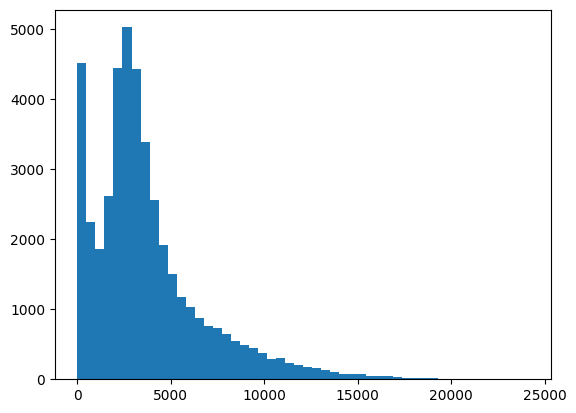

In [5]:
plt.hist((all_features["NumGenesExpressed"]), bins= 50)
print(all_features["MappingRate"].mean())

# 3. Quality Control (QC)

Here, we calculate QC metrics, visualize them, and filter out low-quality cells. This involves removing cells with too few genes, too few counts, or an abnormally high percentage of mitochondrial gene expression, which often indicates cellular stress or damage.

In [6]:
# Identify mitochondrial genes by their 'MT-' prefix
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True, log1p=True)

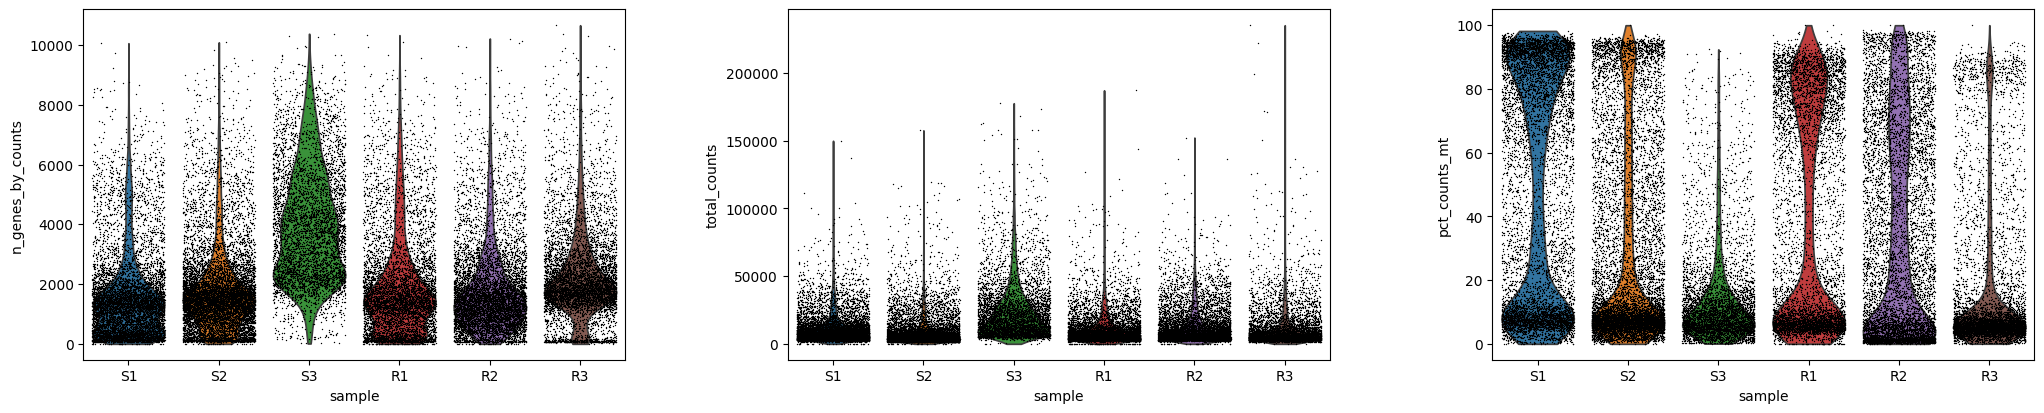

In [7]:
# Visualize QC metrics per sample
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts","pct_counts_mt"],
    jitter=0.4,
    groupby='sample',
    multi_panel=True,
)

In [8]:
for num in adata.obs['sample'].unique():
    print(adata[adata.obs['sample']==num].shape, num)

(7957, 38606) S1
(9986, 38606) S2
(5128, 38606) S3
(6506, 38606) R1
(7772, 38606) R2
(6327, 38606) R3


In [9]:
# Filter genes that are expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)
# Filter cells that express fewer than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
# Filter cells with high mitochondrial gene content (>30%), which are likely stressed or dying
# Normally it would be 15% but since this is cancer we are more lenient
adata = adata[adata.obs.pct_counts_mt < 30, :].copy()
#adata=adata[adata.obs.n_genes_by_counts < 8000, :].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 27373 × 30687
    obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'unspliced'

# 4. Doublet Detection and Removal

This step annotates and removes doublets—technical artifacts where two cells are captured in the same droplet. The results were taken from Socube.

In [11]:
#doublet annotation

df=pd.read_csv('final_result_30.csv')
map2= dict(zip(df['0'], df['predict_type']))
adata.obs['predict_type'] =adata.obs_names.map(map2)
map3= dict(zip(df['0'], df['predict_score']))
adata.obs['predict_score'] =adata.obs_names.map(map3)




In [12]:
#doublet removal
adata= adata[adata.obs['predict_type'] != 'doublet']

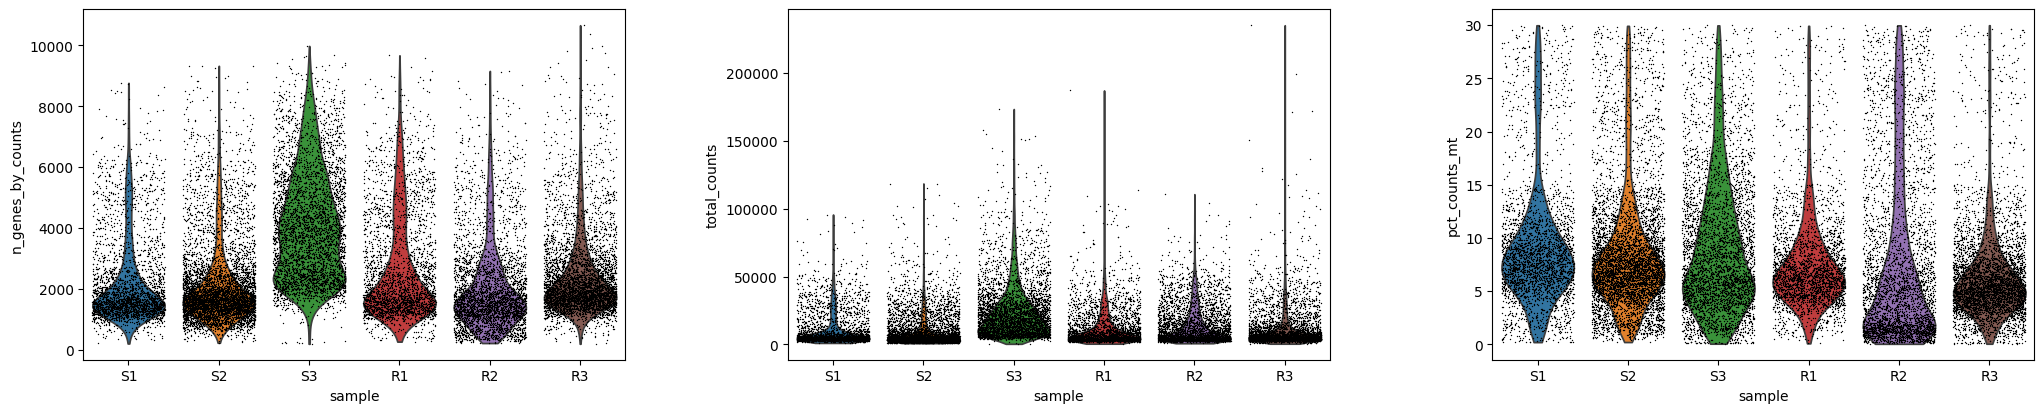

In [56]:
sc.pl.violin(
    adata_sc,
    ["n_genes_by_counts", "total_counts","pct_counts_mt"],
    jitter=0.4,
    groupby='sample',
    multi_panel=True,
)

In [4]:
adata.obs.describe()

n_genes_by_counts  log1p_n_genes_by_counts   total_counts  \
count       24828.000000             24828.000000   24828.000000   
mean         2575.159336                 7.675865   13082.532227   
std          1650.250652                 0.593726   15707.949219   
min           206.000000                 5.332719     474.000000   
25%          1460.000000                 7.286876    3971.000000   
50%          1979.000000                 7.590852    6243.000000   
75%          3204.000000                 8.072467   16520.250000   
max         10664.000000                 9.274723  235276.000000   

       log1p_total_counts  pct_counts_in_top_50_genes  \
count        24828.000000                24828.000000   
mean             8.999960                   41.697054   
std              0.928311                   17.097743   
min              6.163315                   17.240739   
25%              8.287025                   31.138432   
50%              8.739376                   36.148809   
75%              9.712403                   43.326025   
max             12.368519                   97.501496   

       pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
count                 24828.000000                 24828.000000   
mean                     51.586201                    60.842133   
std                      15.122688                    12.948289   
min                      24.857590                    33.124210   
25%                      41.539823                    52.133373   
50%                      47.383308                    57.688538   
75%                      55.522935                    65.108589   
max                      98.399162                    99.895272   

       pct_counts_in_top_500_genes  total_counts_mt  log1p_total_counts_mt  \
count                 24828.000000     24828.000000           24828.000000   
mean                     73.381677      1203.848145               6.203908   
std                       9.949172      2350.775879               1.221154   
min                      46.963809         3.000000               1.386294   
25%                      66.517721       238.000000               5.476464   
50%                      71.556569       392.000000               5.973810   
75%                      77.732389       852.000000               6.748760   
max                     100.000000     34572.000000              10.450829   

       pct_counts_mt       n_genes  predict_score  
count   24828.000000  24828.000000   2.482800e+04  
mean        8.037333   2575.057838   1.230834e-02  
std         5.925304   1650.169613   5.050291e-02  
min         0.052238    206.000000   5.620934e-11  
25%         4.334488   1460.000000   2.749228e-06  
50%         6.540098   1979.000000   5.488961e-05  
75%         9.827199   3204.000000   1.248847e-03  
max        29.997984  10664.000000   4.999524e-01

In [14]:
# Saves raw counts before normalization this are used in DGE downstream
adata.layers['counts'] = adata.X.copy()

In [2]:
adata=ad.read_h5ad('raw_counts.h5ad')

# 5. Normalization and Scaling

We normalize the count data to account for differences in sequencing depth between cells, followed by log-transformation to stabilize variance. We then identify highly variable genes (HVGs) for downstream analysis and scale the data to have zero mean and unit variance.

In [3]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
  

In [4]:
sc.pp.highly_variable_genes(adata, batch_key = 'sample')

var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]

In [5]:
sc.pp.regress_out(adata, ["pct_counts_mt", "total_counts"])
sc.pp.scale(adata, max_value=10)

# 6. Batch Correction with Scanorama

To mitigate batch effects between different samples, we use Scanorama to integrate the datasets. This aligns the cells from different batches in a shared embedding space.

In [6]:
# Split the AnnData object into a list of objects, one for each sample
batch_key = 'sample'
adatas = [adata[adata.obs[batch_key] == batch_value][:, var_genes].copy() for batch_value in adata.obs[batch_key].unique()]
adatas

[AnnData object with n_obs × n_vars = 3239 × 3403
     obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'predict_type', 'predict_score'
     var: 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
     uns: 'sample_colors', 'log1p', 'hvg'
     layers: 'counts', 'unspliced',
 AnnData object with n_obs × n_vars = 6267 × 3403
     obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_co

In [7]:
scanorama.integrate_scanpy(adatas, dimred = 100)
adatas

Found 3403 genes among all datasets
[[0.         0.48163013 0.26057425 0.44859525 0.40412833 0.48996604]
 [0.         0.         0.39588689 0.61590629 0.68962945 0.50467476]
 [0.         0.         0.         0.42046856 0.24521263 0.48836284]
 [0.         0.         0.         0.         0.4095996  0.62422916]
 [0.         0.         0.         0.         0.         0.31111664]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (1, 4)
Processing datasets (3, 5)
Processing datasets (1, 3)
Processing datasets (1, 5)
Processing datasets (0, 5)
Processing datasets (2, 5)
Processing datasets (0, 1)
Processing datasets (0, 3)
Processing datasets (2, 3)
Processing datasets (3, 4)
Processing datasets (0, 4)
Processing datasets (1, 2)
Processing datasets (4, 5)
Processing datasets (0, 2)
Processing datasets (2, 4)


[AnnData object with n_obs × n_vars = 3239 × 3403
     obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'predict_type', 'predict_score'
     var: 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
     uns: 'sample_colors', 'log1p', 'hvg'
     obsm: 'X_scanorama'
     layers: 'counts', 'unspliced',
 AnnData object with n_obs × n_vars = 6267 × 3403
     obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_

In [8]:
# Create a copy of the scaled data object to store the integrated results
adata_sc = adata.copy()

# Extract the corrected embeddings ('X_scanorama') from each integrated object
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# Concatenate the embeddings into a single matrix
all_s = np.concatenate(scanorama_int)

# Add the combined, corrected embeddings to the main analysis object
adata_sc.obsm['X_scanorama'] = all_s
adata_sc

AnnData object with n_obs × n_vars = 26077 × 30687
    obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'predict_type', 'predict_score'
    var: 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg'
    obsm: 'X_scanorama'
    layers: 'counts', 'unspliced'

In [9]:
# Subset the integrated object to only include the highly variable genes used for integration
adata_sc = adata_sc[:, adata_sc.var.highly_variable]

In [10]:
sc.tl.pca(adata, svd_solver="arpack")

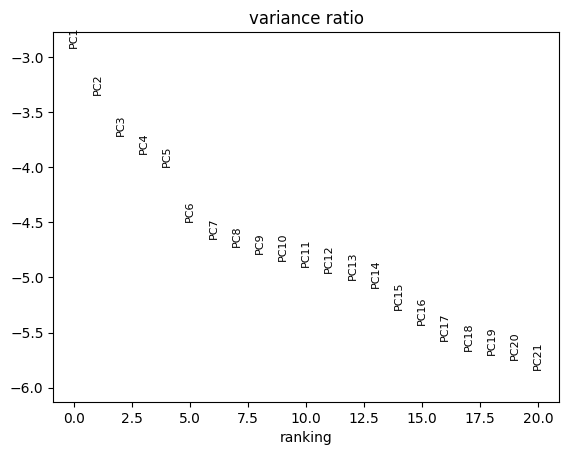

In [11]:
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)

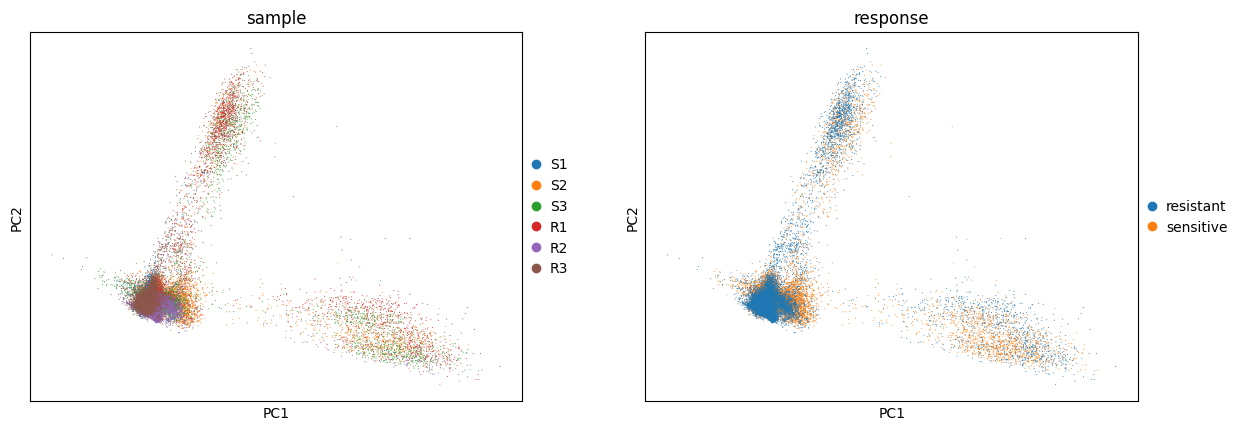

In [12]:
sc.pl.pca(
    adata,
    color=["sample","response"],
    ncols=2,
    size=2,
)

# 7. Clustering and Visualization

Using the batch-corrected embedding from Scanorama, we build a nearest-neighbor graph, perform clustering using the Leiden algorithm, and generate a UMAP plot for 2D visualization of the cell populations.

In [13]:
# Compute the nearest-neighbor graph on the 'X_scanorama' corrected embeddings
sc.pp.neighbors(adata_sc, use_rep='X_scanorama', n_neighbors=50) #,metric='cosine')

# Compute the UMAP embedding for visualization
sc.tl.umap(adata_sc)


In [14]:
# Perform cell clustering using the Leiden algorithm
sc.tl.leiden(adata_sc, flavor="igraph", n_iterations=2, resolution = 0.7)

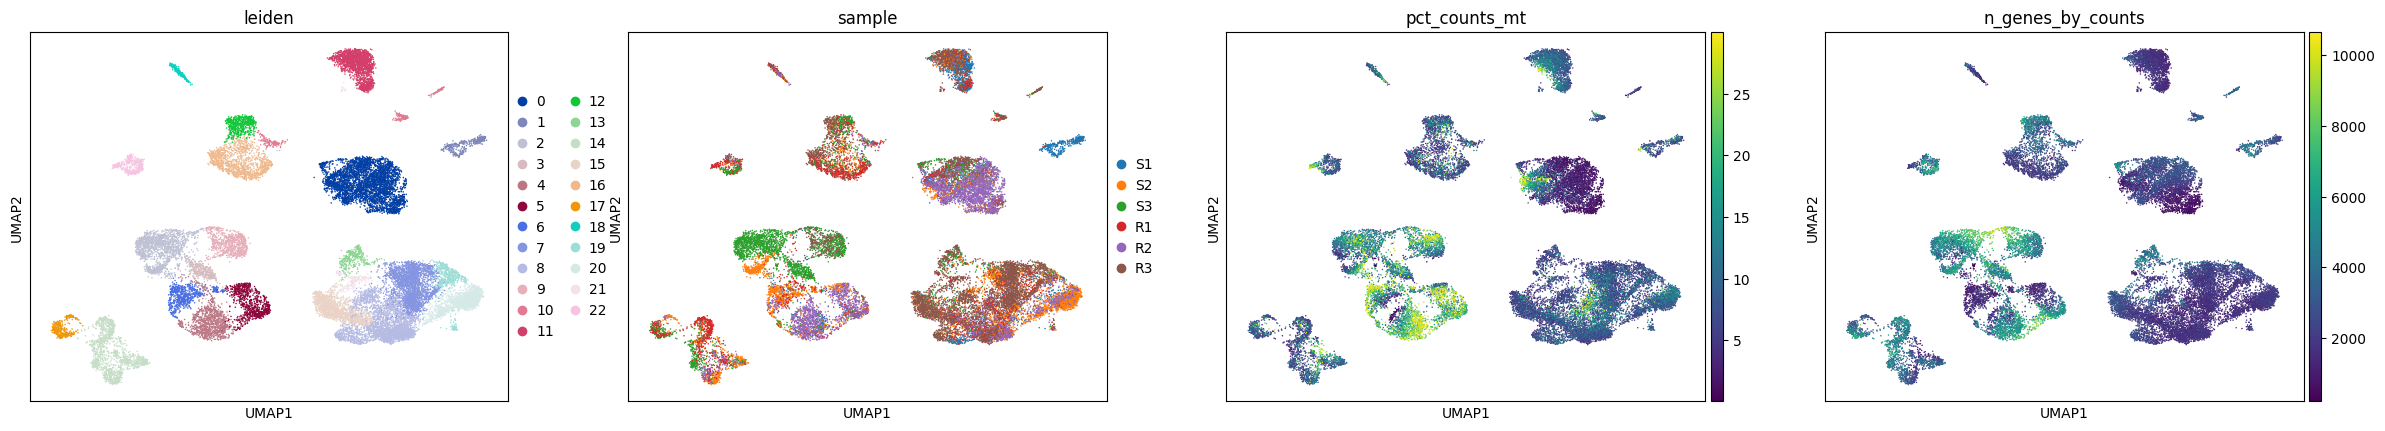

In [15]:
sc.pl.umap(adata_sc, color=["leiden",'sample','pct_counts_mt','n_genes_by_counts',] )  


In [16]:
adata_sc.write_h5ad('intergrated.h5ad')

In [5]:
adata_sc = sc.read_h5ad('intergrated.h5ad')

# 8. Automated Cell Type Annotation

We use Decoupler and the PanglaoDB marker gene database to perform an initial, automated cell type annotation. This involves scoring each cell for its enrichment of known cell type-specific gene signatures.

In [6]:
# Load marker genes for human from PanglaoDB via decoupler
markers =dc.op.resource(name="PanglaoDB", organism="human")

# Filter the marker set for high-confidence, canonical markers
markers = markers[
    markers["human"].astype(bool)
    & markers["canonical_marker"].astype(bool)
    & (markers["human_sensitivity"].astype(float) > 0.5)
]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]
markers

source   target
                                               
18    Pulmonary alveolar type II cells    ABCA3
90                         Enterocytes    ACSL5
105                Smooth muscle cells    ACTA2
113                Smooth muscle cells    ACTG2
114                Myoepithelial cells    ACTG2
...                                ...      ...
8092                 Endothelial cells      VWF
8101          Luminal epithelial cells    WFDC2
8102                      Ductal cells    WFDC2
8129                         Podocytes      WT1
8197                   Ependymal cells  ZMYND10

[690 rows x 2 columns]

In [7]:
# Run the ULM (Univariate Linear Model) method to score each cell against the marker gene sets
dc.mt.ulm(data=adata_sc, net=markers, tmin=3)

In [8]:
# The results are stored in the .obsm slot of the AnnData object
adata_sc.obsm['score_ulm']

Acinar cells  Adipocytes  Alpha cells  Astrocytes  \
S1_GCACATACAGTTCTAG     -4.333983   -1.741569     0.311041   -0.397477   
S1_ACTGTGACATGAAGCG     -4.738393   -1.220187    -0.181853   -0.682790   
S1_CATGGATGTGATTAGA     -4.514428   -1.762449     0.411517   -0.247898   
S1_AGAACAAGTGGTTTAC     -3.346070   -1.044222    -0.408032   -0.605764   
S1_TTGCATTGTGATTAGA     -4.255239   -1.834445     0.197718   -0.370666   
...                           ...         ...          ...         ...   
R3_AAAGTCCCAGCTCATA     -2.195991   -0.619811    -0.221808    1.077596   
R3_CTGGCAGTCGCTAATG     -0.259841    0.178238    -0.257346   -0.574223   
R3_ATTCTTGCACGGAAGT     -1.032072    0.008692    -0.193608   -0.452959   
R3_ACGATCAGTCCGGATC     -0.521007   -0.177745    -0.176423    0.713385   
R3_ATGGTTGCACAGTATC     -0.177767   -0.069827    -0.200017   -0.515044   

                      B cells  B cells naive  Beta cells  Cholangiocytes  \
S1_GCACATACAGTTCTAG  1.736773       2.617687    0.249751       -5.438394   
S1_ACTGTGACATGAAGCG  1.226929       2.490754   -0.263375       -6.728647   
S1_CATGGATGTGATTAGA  0.188831       1.152224    0.379265       -5.757028   
S1_AGAACAAGTGGTTTAC  5.655494       7.823423   -0.469962       -4.770739   
S1_TTGCATTGTGATTAGA  0.301319       1.454217    0.173435       -4.978831   
...                       ...            ...         ...             ...   
R3_AAAGTCCCAGCTCATA -0.681176      -0.485649   -0.388319       -4.856413   
R3_CTGGCAGTCGCTAATG  0.083512      -0.707927   -0.455101        0.895653   
R3_ATTCTTGCACGGAAGT  1.175763      -0.370946   -0.413762       -2.291522   
R3_ACGATCAGTCCGGATC -0.579189      -0.861072   -0.401411       -1.180228   
R3_ATGGTTGCACAGTATC  2.951726       1.725285   -0.395948        1.018197   

                     Dendritic cells  Ductal cells  ...  \
S1_GCACATACAGTTCTAG        -2.818459     -4.470610  ...   
S1_ACTGTGACATGAAGCG        -1.930681     -3.438521  ...   
S1_CATGGATGTGATTAGA        -3.564518     -4.499105  ...   
S1_AGAACAAGTGGTTTAC         0.901379     -2.805085  ...   
S1_TTGCATTGTGATTAGA        -2.495418     -4.119689  ...   
...                              ...           ...  ...   
R3_AAAGTCCCAGCTCATA        -1.462608     -2.011089  ...   
R3_CTGGCAGTCGCTAATG         0.922308     -0.295776  ...   
R3_ATTCTTGCACGGAAGT         0.389163     -0.114616  ...   
R3_ACGATCAGTCCGGATC         2.889979      0.516101  ...   
R3_ATGGTTGCACAGTATC         2.470487      0.510232  ...   

                     Pancreatic stellate cells  Pericytes  Plasma cells  \
S1_GCACATACAGTTCTAG                  -2.359301  -0.822403     15.178757   
S1_ACTGTGACATGAAGCG                  -1.890017  -0.152080      5.750757   
S1_CATGGATGTGATTAGA                  -2.186527  -1.065169      1.865306   
S1_AGAACAAGTGGTTTAC                  -1.810370  -0.860057      2.949523   
S1_TTGCATTGTGATTAGA                  -2.069917  -1.499481      5.417963   
...                                        ...        ...           ...   
R3_AAAGTCCCAGCTCATA                  -0.096951  -0.178372      1.558786   
R3_CTGGCAGTCGCTAATG                  -0.267426  -0.315267     -0.511113   
R3_ATTCTTGCACGGAAGT                  -0.605379   0.009570      0.398640   
R3_ACGATCAGTCCGGATC                  -0.742347   0.420032     -0.404093   
R3_ATGGTTGCACAGTATC                   0.748508  -0.492084      0.880162   

                     Plasmacytoid dendritic cells  Platelets  Podocytes  \
S1_GCACATACAGTTCTAG                      2.860803  -0.047783  -1.037438   
S1_ACTGTGACATGAAGCG                      2.160058  -0.045745  -1.321043   
S1_CATGGATGTGATTAGA                      2.803555  -0.096257  -0.940425   
S1_AGAACAAGTGGTTTAC                      1.811561  -0.734282  -1.218653   
S1_TTGCATTGTGATTAGA                      1.710746  -0.515519  -0.775525   
...                                           ...        ...        ...   
R3_AAAGTCCCAGCTCATA                     -0.230690   0.192505  -0.503140   
R3_CTGGCA

In [9]:
# Extract the scores into a separate AnnData object for easier manipulation and visualization
score = dc.pp.get_obsm(adata_sc, key="score_ulm")
score

AnnData object with n_obs × n_vars = 26077 × 42
    obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'predict_type', 'predict_score', 'leiden'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'score_ulm', 'padj_ulm'

In [10]:
# Identify the top enriched cell types for each Leiden cluster to guide manual annotation
df = dc.tl.rankby_group(adata=score, groupby="leiden", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

group reference                                          name       stat  \
0       0      rest                                  Plasma cells  91.066862   
1       0      rest                  Plasmacytoid dendritic cells  58.101745   
10      0      rest                         Enteroendocrine cells  33.889572   
11      0      rest                                   Alpha cells  27.392587   
24      0      rest                                   Enterocytes  13.832243   
..    ...       ...                                           ...        ...   
958    22      rest                           Smooth muscle cells   4.668683   
960    22      rest                              Oligodendrocytes   3.605446   
962    22      rest                           Loop of Henle cells   2.632401   
963    22      rest                                    Astrocytes   2.431158   
964    22      rest  Erythroid-like and erythroid precursor cells   1.901464   

     meanchange           pval           padj  
0      5.601253   0.000000e+00   0.000000e+00  
1      1.634909   0.000000e+00   0.000000e+00  
10     0.509507  1.377298e-235  5.258772e-235  
11     0.415639  7.582789e-158  2.653976e-157  
24     0.471255   5.991304e-43   1.006539e-42  
..          ...            ...            ...  
958    0.425250   3.689144e-06   4.426973e-06  
960    0.252684   3.317553e-04   3.765871e-04  
962    0.172849   8.638691e-03   9.303206e-03  
963    0.128611   1.528592e-02   1.605022e-02  
964    0.128584   5.758399e-02   5.898848e-02  

[283 rows x 7 columns]

In [11]:
# Create a dictionary showing the top 3 candidate cell types for each cluster
n_ctypes = 3
ctypes_dict = df.groupby("group").head(n_ctypes).groupby("group")["name"].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Plasma cells',
  'Plasmacytoid dendritic cells',
  'Enteroendocrine cells'],
 '1': ['B cells naive', 'B cells', 'Mast cells'],
 '10': ['Dendritic cells', 'Macrophages', 'Plasmacytoid dendritic cells'],
 '11': ['B cells naive', 'B cells', 'Plasmacytoid dendritic cells'],
 '12': ['Macrophages', 'Dendritic cells', 'Astrocytes'],
 '13': ['T cells', 'NK cells', 'Gamma delta T cells'],
 '14': ['Fibroblasts', 'Hepatic stellate cells', 'Adipocytes'],
 '15': ['T cells', 'Neutrophils', 'B cells naive'],
 '16': ['Neutrophils', 'Dendritic cells', 'Macrophages'],
 '17': ['Mesangial cells', 'Pericytes', 'Hepatic stellate cells'],
 '18': ['Mast cells', 'Neutrophils', 'Platelets'],
 '19': ['Gamma delta T cells', 'NK cells', 'Platelets'],
 '2': ['Ductal cells', 'Mammary epithelial cells', 'Luminal epithelial cells'],
 '20': ['Gamma delta T cells', 'NK cells', 'T cells'],
 '21': ['Neutrophils', 'Monocytes', 'Dendritic cells'],
 '22': ['Endothelial cells', 'Podocytes', 'Platelets'],
 '3': ['Acina

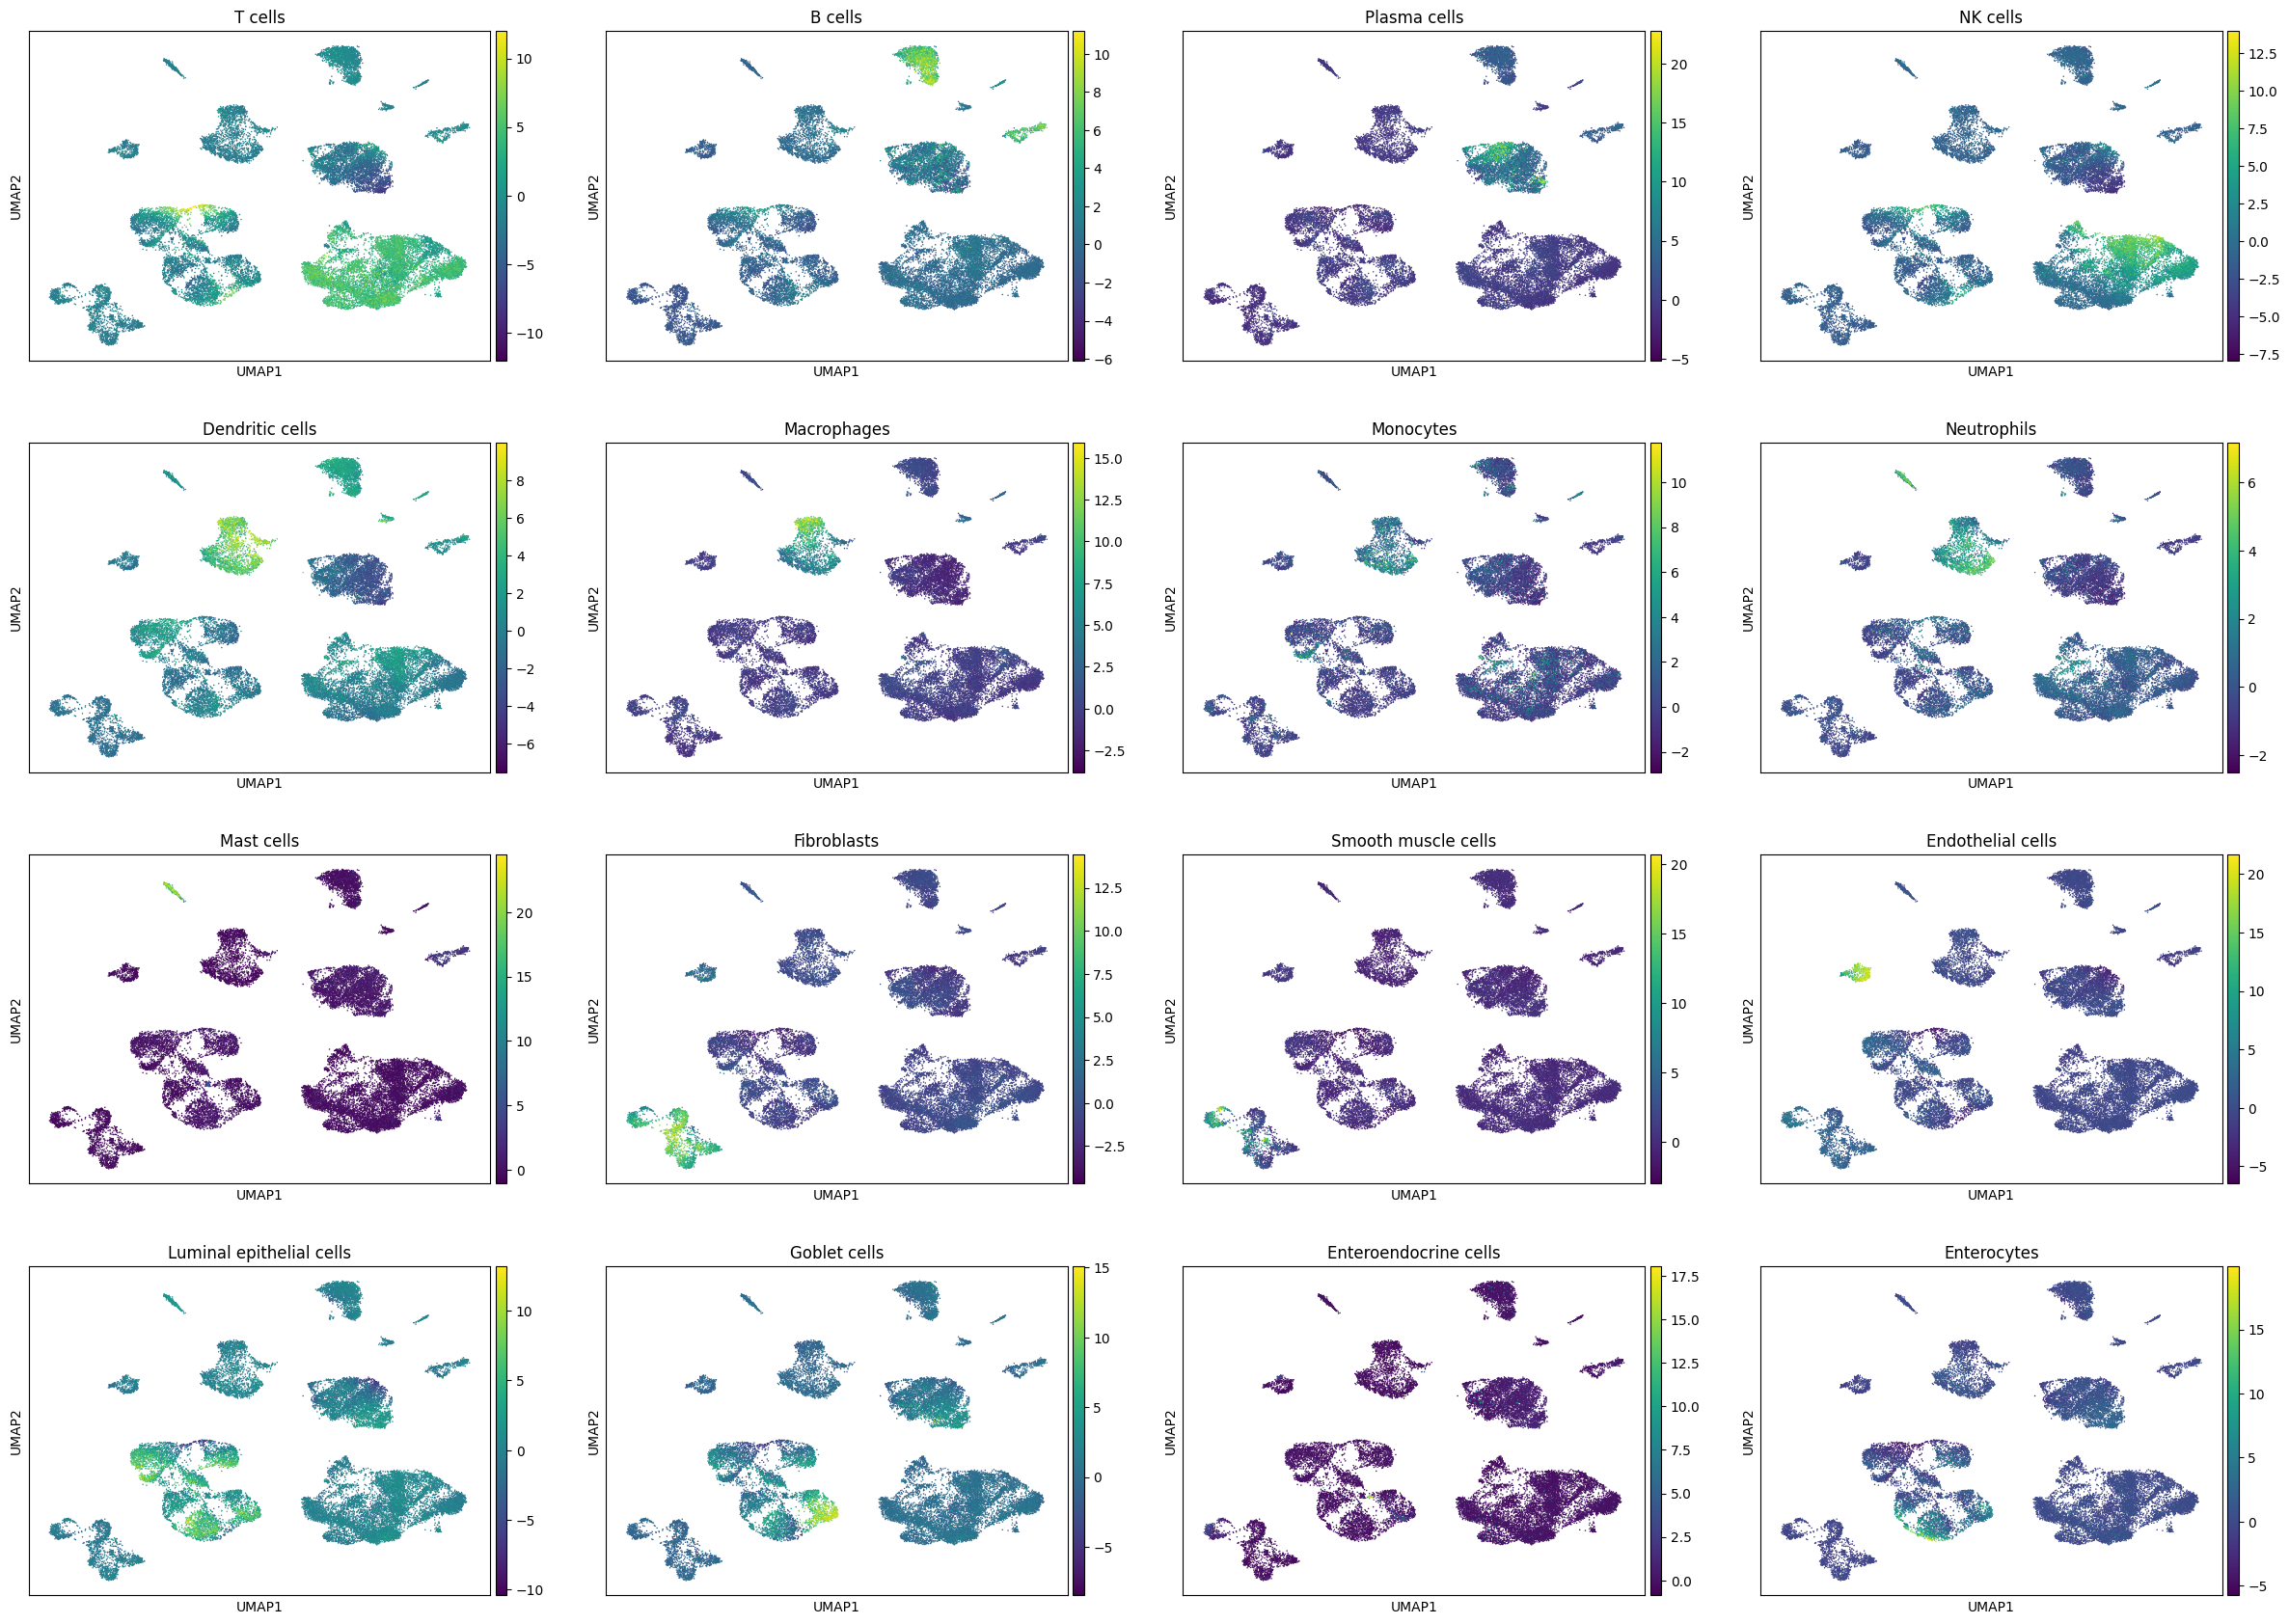

2025-10-30 13:38:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 13:38:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 13:38:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 13:38:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 13:38:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

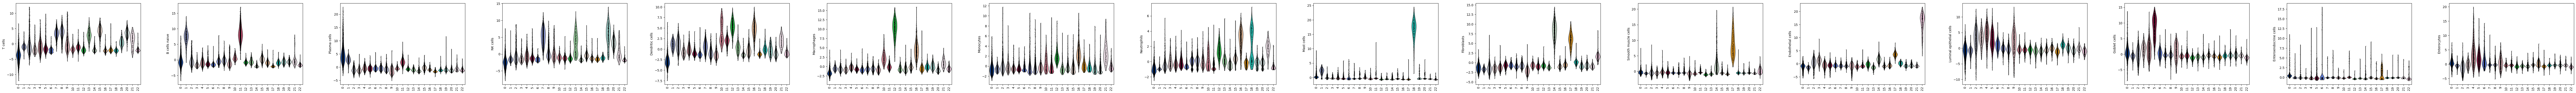

In [12]:
# Visualize the enrichment scores for key cell types on the UMAP
sc.pl.umap(score, color=["T cells","B cells","Plasma cells","NK cells","Dendritic cells","Macrophages", "Monocytes","Neutrophils","Mast cells","Fibroblasts","Smooth muscle cells","Endothelial cells","Luminal epithelial cells","Goblet cells","Enteroendocrine cells","Enterocytes",])

# Visualize the distribution of scores per cluster using violin plots
sc.pl.violin(score,keys=["T cells","B cells naive","Plasma cells","NK cells","Dendritic cells","Macrophages", "Monocytes","Neutrophils","Mast cells","Fibroblasts","Smooth muscle cells","Endothelial cells","Luminal epithelial cells","Goblet cells","Enteroendocrine cells","Enterocytes",],groupby="leiden",rotation=90)


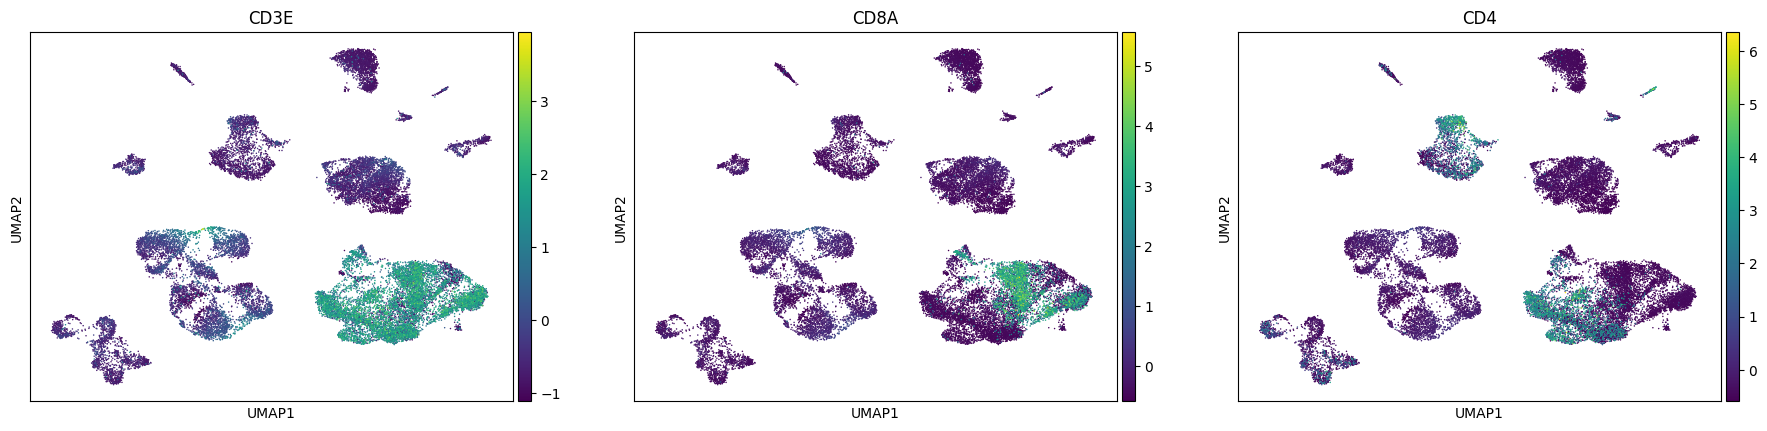

In [13]:
sc.pl.umap(adata_sc, color=['CD3E','CD8A','CD4'])

# 9. Manual Cell Type Annotation and Refinement

Based on the automated annotation results and canonical marker expression, we manually assign a final cell type identity to each Leiden cluster. We then perform a final filtering step to refine the dataset for differential expression analysis.

In [14]:
bdata= ad.read_h5ad('DGE_latest.h5ad')

In [15]:
# Build a mapping dataframe from bdata
map_df = bdata.obs[["cell_type"]].copy()
map_df.index.name = "obs_names"

# Reindex to adata obs_names
adata_sc.obs["cell_type"] = map_df.reindex(adata_sc.obs_names)["cell_type"]


In [16]:
celltype = {
    "0": "Plasma-cells",
    "1": "B-cells",
    "2": "Epithelial-cells",
    "3": "Epithelial-cells",
    "4": "Epithelial-cells",
    "5": "Epithelial-cells",
    "6": "Epithelial-cells",
    "7": "T-cells",
    "8": "T-cells",
    "9": "Epithelial-cells",
    "10": "Myeloid-cells",
    "11": "B-cells",
    "12": "Myeloid-cells",
    "13": "T-cells",
    "14": "Fibroblasts",
    "15": "T-cells",
    "16": "Myeloid-cells",
    "17": "Fibroblasts",
    "18": "Mast-cells",
    "19": "T-cells",
    "20": "T-cells",
    "21": "T-cells",
    "22": "Endothelial-cells"
}


In [17]:
# Map the dictionary to the 'leiden' column to create a new 'celltype' annotation
adata_sc.obs["celltype"] = adata_sc.obs["leiden"].map(celltype)


... storing 'celltype' as categorical


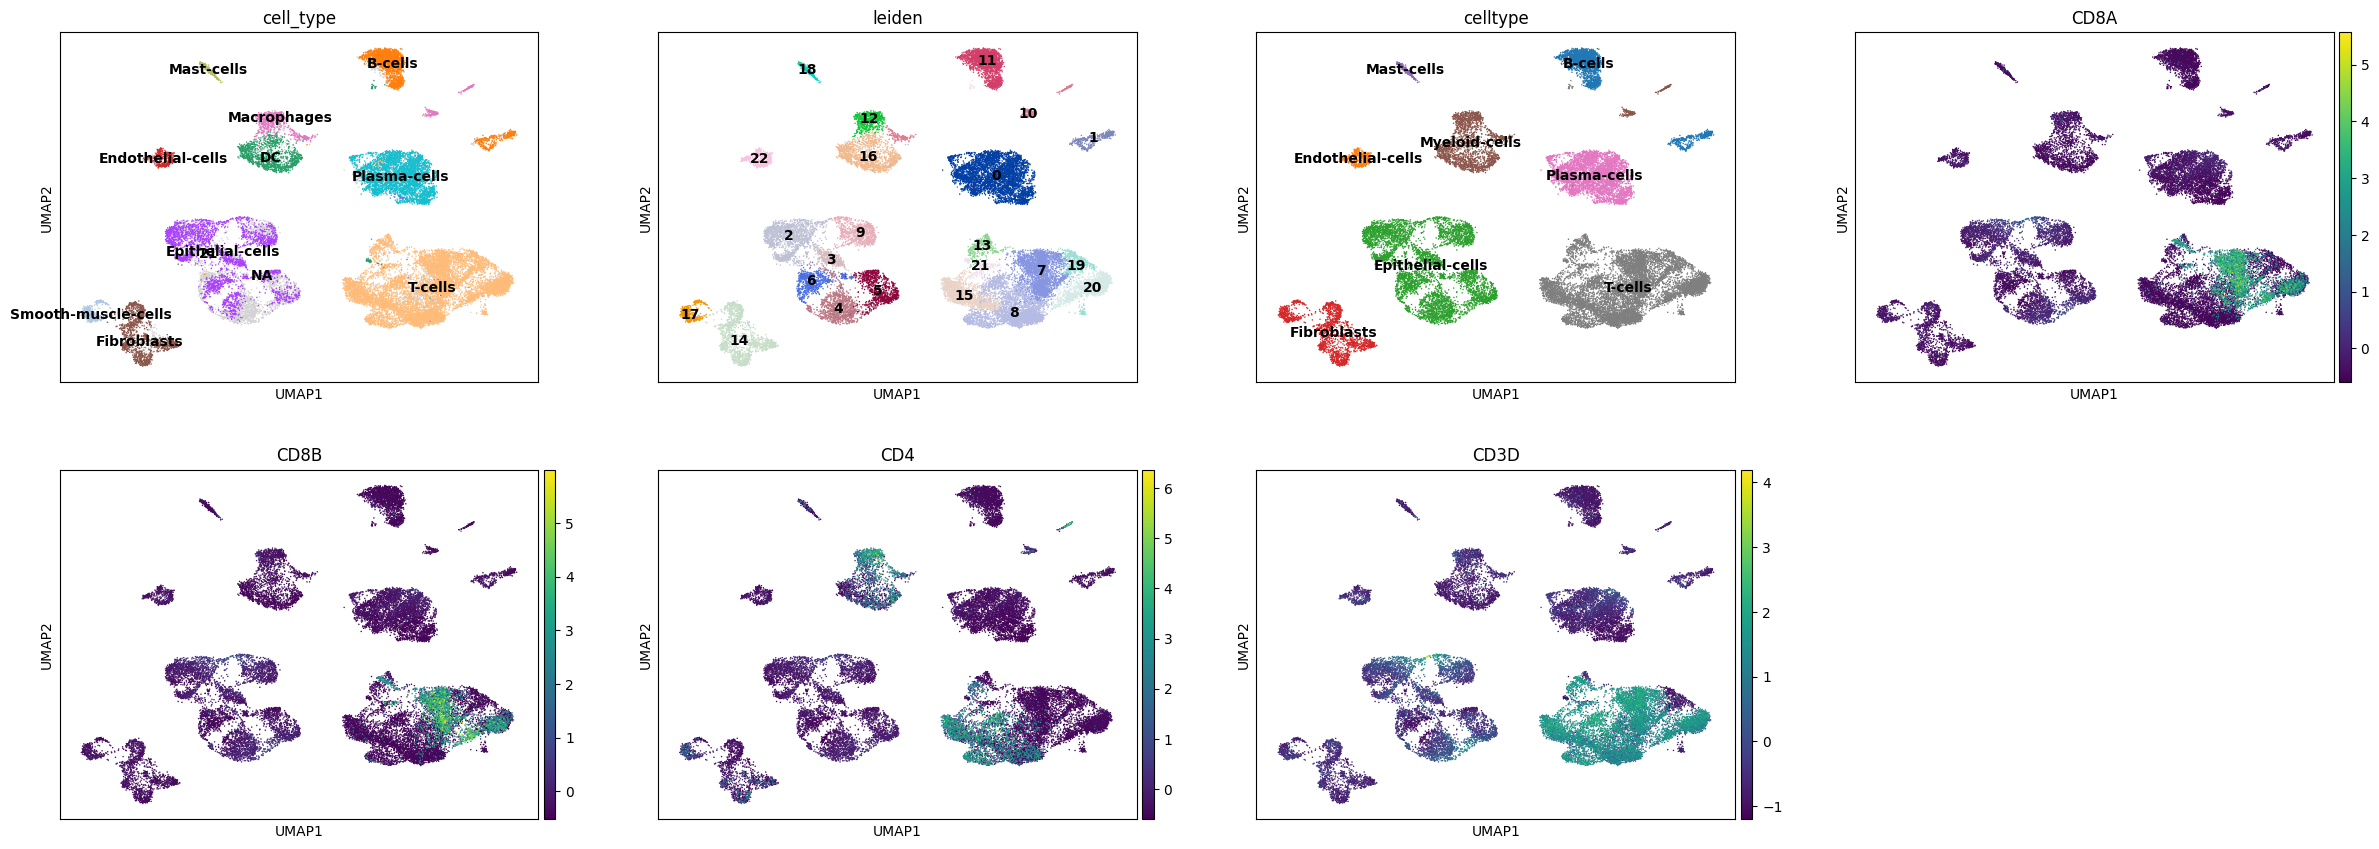

In [18]:
# Visualize the final manual annotations on the UMAP to confirm consistency
sc.pl.umap(
    adata=adata_sc,
    color=["cell_type",'leiden','celltype','CD8A','CD8B','CD4','CD3D'],
    legend_loc="on data",
)

In [19]:
sc.tl.rank_genes_groups(adata_sc, groupby="celltype", method="wilcoxon")

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encounter

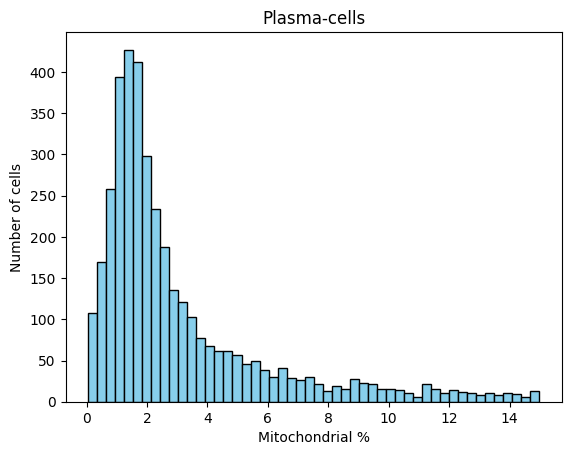

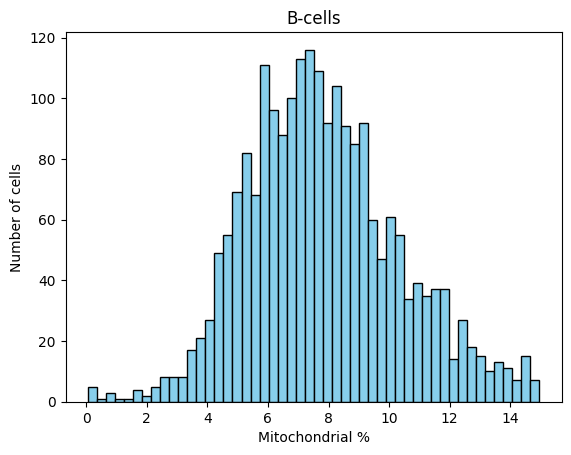

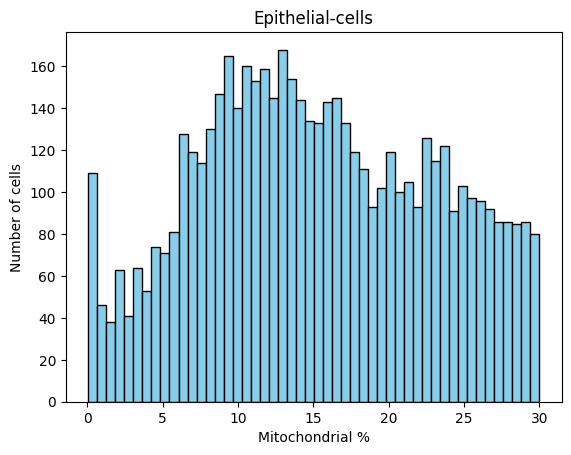

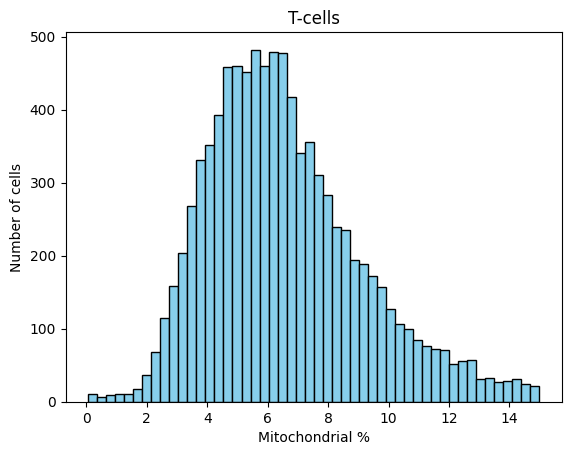

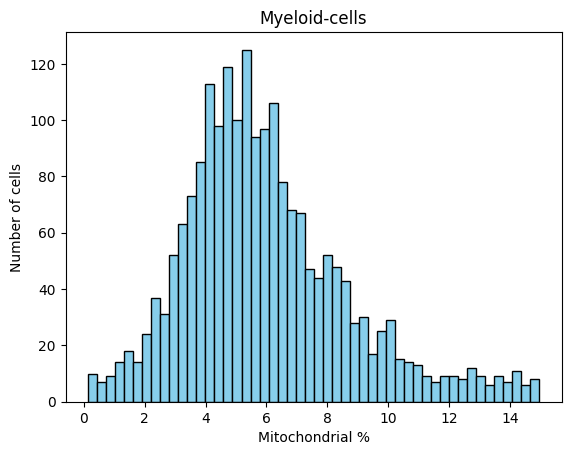

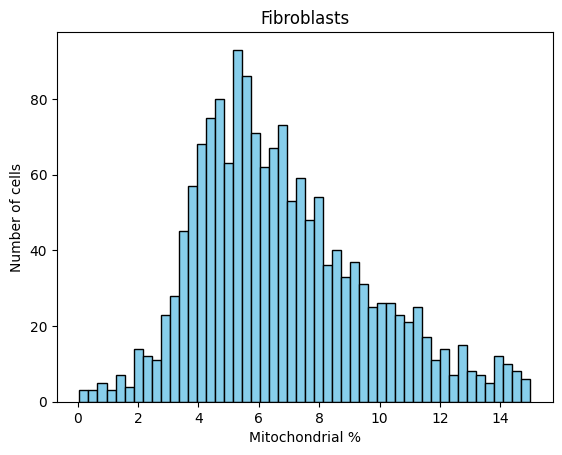

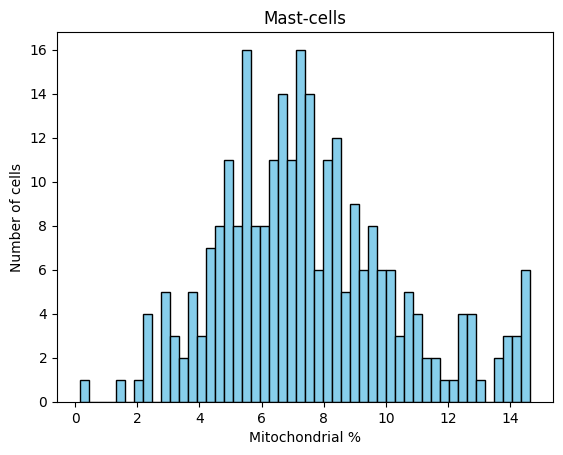

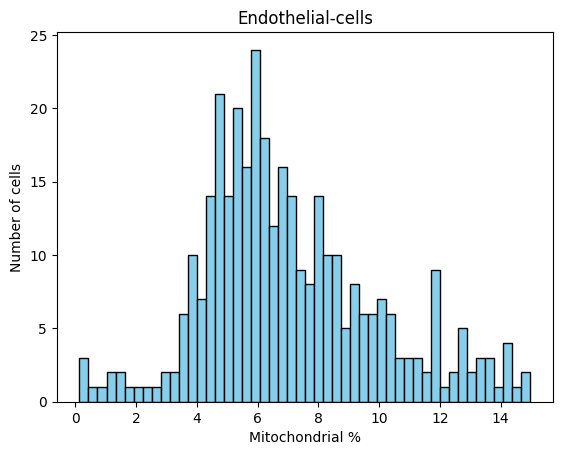

In [31]:
plt.style.use('ggplot')
for celltype in adata_sc.obs.celltype.unique():
    plt.hist(adata_sc.obs.loc[adata_sc.obs['celltype'] == celltype, 'pct_counts_mt'],bins=50, color= 'skyblue', edgecolor ='black')
    plt.xlabel('Mitochondrial %')
    plt.ylabel('Number of cells')
    plt.title(celltype)
    plt.show()

In [32]:
# Keep all epithelial cells, plus other cells with mt% < 15
# only cancer cells are expected to have more than 15% mt
adata_sc = adata_sc[
    (adata_sc.obs['celltype'] == 'Epithelial-cells') |
    (adata_sc.obs['pct_counts_mt'] < 15),
    :
].copy()


In [33]:
for num in adata_sc.obs['sample'].unique():
    print(adata_sc[adata_sc.obs['sample']==num].shape, num)

(2966, 3124) S1
(5967, 3124) S2
(4212, 3124) S3
(2971, 3124) R1
(3873, 3124) R2
(4839, 3124) R3


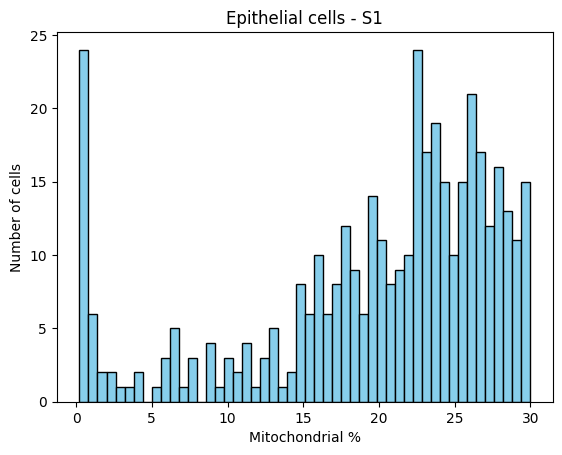

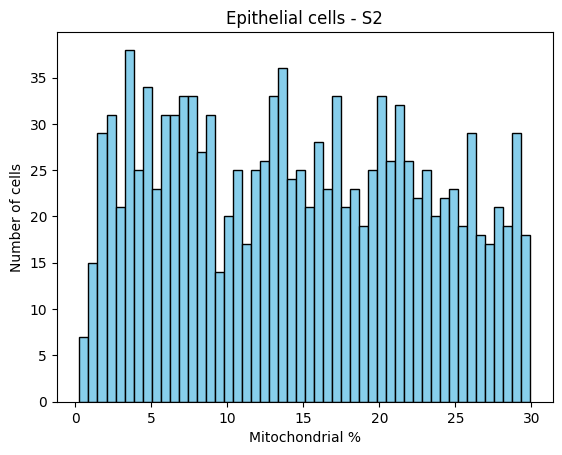

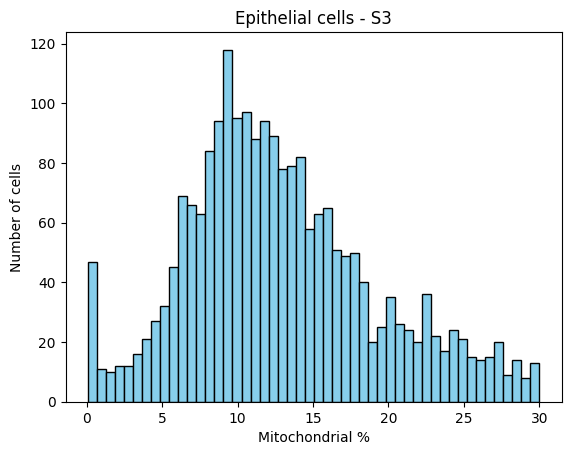

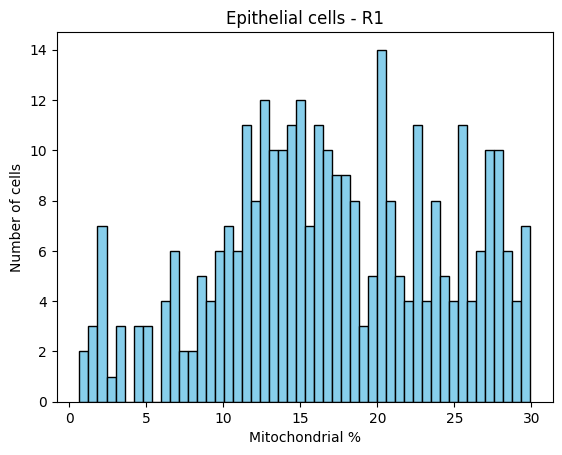

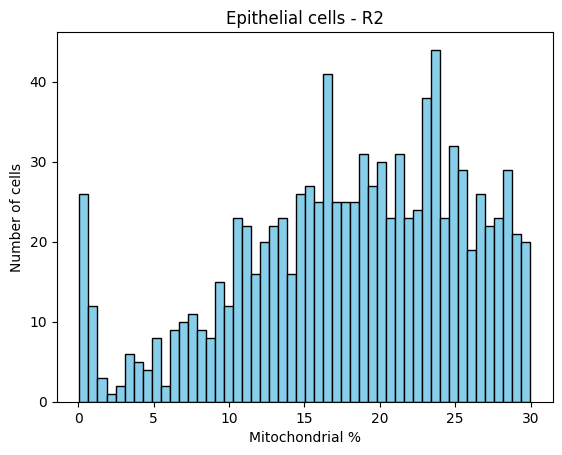

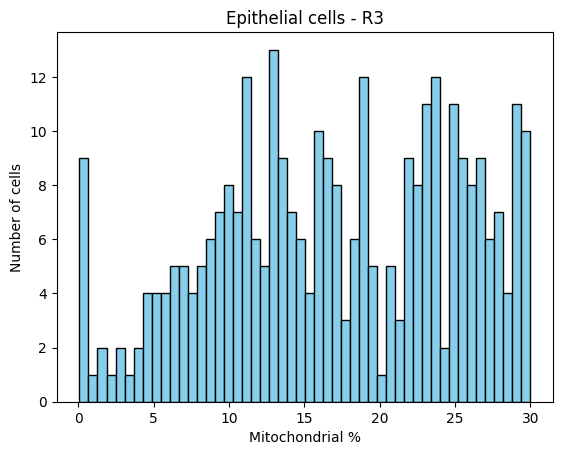

In [34]:
epi = adata_sc.obs[adata_sc.obs['celltype'] == 'Epithelial-cells']

# loop through each unique sample
for sample in epi['sample'].unique():
    subset = epi.loc[epi['sample'] == sample, 'pct_counts_mt']
    plt.hist(subset, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Mitochondrial %')
    plt.ylabel('Number of cells')
    plt.title(f"Epithelial cells - {sample}")
    plt.show()

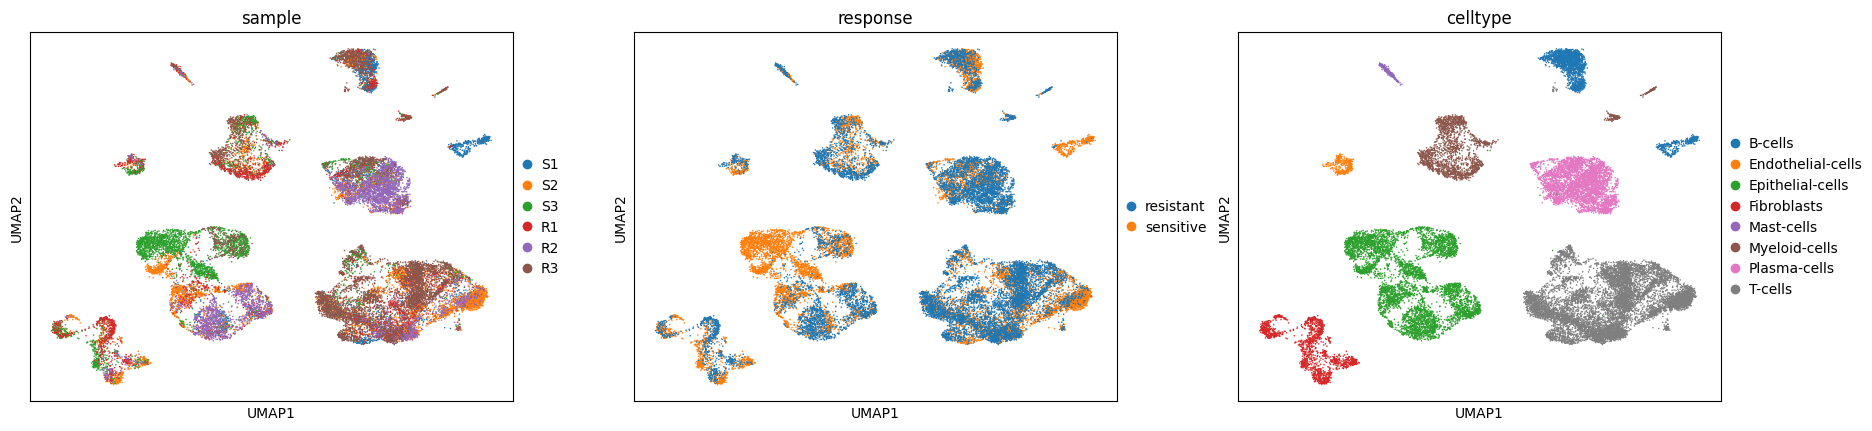

In [36]:
sc.pl.umap(
    adata=adata_sc,
    color=['sample','response','celltype']
    
)

In [ ]:
adata.obs["leiden"] = adata_sc.obs["leiden"]
adata.obs["celltype"] = adata_sc.obs["celltype"]
#adata.obs["cells"] = adata_sc.obs["cells"]


In [73]:
adata = adata[
    (adata.obs['celltype'] == 'Epithelial-cells') |
    (adata.obs['pct_counts_mt'] < 15),
    :
].copy()

# 10. Pseudobulking

To perform differential expression analysis robustly, we aggregate the counts of all cells of the same type within each sample. This process, called pseudobulking, creates bulk-like expression profiles for each cell type and sample, which are more suitable for statistical models like DESeq2.

In [2]:
adata=ad.read_h5ad('dge1.h5ad')

In [110]:
adata.write_h5ad('dge1.h5ad')

# 11. Differential Gene Expression (DGE) Analysis

We use the `pydeseq2` package to perform differential gene expression analysis on the pseudobulk data. This is done for each cell type separately to identify genes that are significantly different between the 'resistant' and 'sensitive' conditions.

In [83]:
# Build DESeq2 object
# Initialize a dictionary to store DGE results for each cell type
results={}
for celltype in pdata.obs["celltype"].unique():
    sub= pdata[pdata.obs["celltype"] == celltype, :].copy()
    dds = DeseqDataSet(
    adata= sub,
    design="~ response",
    refit_cooks=True,
    )

# Compute LFCs
    dds.deseq2()

# Extract contrast between conditions
    stat_res = DeseqStats(dds, n_cpus=12, contrast=('response', 'resistant', 'sensitive'))
    

# Compute Wald test
    stat_res.summary()
    de  = stat_res.results_df
    results[celltype]=de

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 5.45 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 8.22 seconds.

Fitting LFCs...
... done in 8.10 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.86 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             17.445763       -0.141446  0.833679 -0.169665  0.865274   
ENSG00000285639   3.907183        2.299683  1.615282  1.423703  0.154532   
SERTM2            0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838   0.058790        0.002817  2.418308  0.001165  0.999070   
ENSG00000289333   0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ENSG00000288851   2.439790       -0.007649  1.034758 -0.007392  0.994102   
SRFBP1           25.153465       -0.714634  0.750692 -0.951968  0.341113   
ENSG00000286876   0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   1.157543        0.071411  1.549925  0.046074  0.963251   
ENSG00000234848   

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 5.54 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 6.84 seconds.

Fitting LFCs...
... done in 6.88 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.65 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             13.639498        0.143459  1.295644  0.110724  0.911835   
ENSG00000285639   0.000000             NaN       NaN       NaN       NaN   
SERTM2            0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838   0.106862        2.511288  2.882284  0.871284  0.383599   
ENSG00000289333   0.371056        2.340420  2.298807  1.018102  0.308630   
...                    ...             ...       ...       ...       ...   
ENSG00000288851   1.795659       -0.977176  1.946524 -0.502011  0.615660   
SRFBP1           37.857004        0.162760  1.174063  0.138630  0.889743   
ENSG00000286876   0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   0.207802        0.748022  2.321804  0.322173  0.747322   
ENSG00000234848   

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.29 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 12.67 seconds.

Fitting LFCs...
... done in 7.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.95 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                                
MFN1             356.821405        0.324022  0.346753  0.934445  0.350074   
ENSG00000285639    0.742222        0.073402  1.458397  0.050330  0.959859   
SERTM2             0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838    5.854933       -2.520531  1.160837 -2.171304  0.029908   
ENSG00000289333    0.000000             NaN       NaN       NaN       NaN   
...                     ...             ...       ...       ...       ...   
ENSG00000288851   17.364464        0.165217  0.581356  0.284193  0.776263   
SRFBP1           497.207150       -0.160834  0.381072 -0.422057  0.672984   
ENSG00000286876    0.497650       -2.082270  4.254015 -0.489483  0.624499   
ENSG00000289569   23.755497       -0.070697  0.764264 -0.092503  0.926298   
ENSG00

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 7.71 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 9.78 seconds.

Fitting LFCs...
... done in 7.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.25 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             48.686006       -0.305052  1.052235 -0.289909  0.771886   
ENSG00000285639   0.000000             NaN       NaN       NaN       NaN   
SERTM2            1.081420        1.551176  1.721403  0.901111  0.367529   
ENSG00000261838   0.171475        0.882898  2.373083  0.372047  0.709858   
ENSG00000289333   0.117181        0.447730  3.377174  0.132575  0.894529   
...                    ...             ...       ...       ...       ...   
ENSG00000288851   2.325145       -1.050789  1.713732 -0.613158  0.539772   
SRFBP1           87.761617       -0.148993  0.423369 -0.351923  0.724896   
ENSG00000286876   0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   2.653209       -0.009333  1.369695 -0.006814  0.994563   
ENSG00000234848   

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.15 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 10.97 seconds.

Fitting LFCs...
... done in 6.16 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.61 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                              
MFN1             2.308210        0.629275  1.274651  0.493684  0.621529   
ENSG00000285639  0.000000             NaN       NaN       NaN       NaN   
SERTM2           0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838  0.000000             NaN       NaN       NaN       NaN   
ENSG00000289333  0.075345       -0.569161  3.305559 -0.172183  0.863294   
...                   ...             ...       ...       ...       ...   
ENSG00000288851  0.760634        0.398218  1.795931  0.221733  0.824522   
SRFBP1           9.069411        0.033966  0.661420  0.051353  0.959045   
ENSG00000286876  0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569  0.119007        1.256708  3.290705  0.381896  0.702538   
ENSG00000234848  0.000000     

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 6.86 seconds.

Fitting dispersion trend curve...
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 10.01 seconds.

Fitting LFCs...
... done in 7.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.30 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             39.483924        0.314905  0.548538  0.574081  0.565913   
ENSG00000285639   0.535412        1.232559  1.546831  0.796829  0.425551   
SERTM2            0.390979       -0.105038  2.392191 -0.043909  0.964977   
ENSG00000261838   7.328502       -0.577257  2.439862 -0.236594  0.812972   
ENSG00000289333   0.147008        0.132548  2.124688  0.062385  0.950256   
...                    ...             ...       ...       ...       ...   
ENSG00000288851   6.480296        1.342409  1.110539  1.208790  0.226743   
SRFBP1           69.207012       -0.056779  0.408064 -0.139143  0.889337   
ENSG00000286876   0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   7.923547       -1.339310  1.315968 -1.017738  0.308803   
ENSG00000234848   

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 8.72 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 8.89 seconds.

Fitting LFCs...
... done in 7.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.43 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             71.580831       -0.134445  0.395405 -0.340017  0.733843   
ENSG00000285639   0.000000             NaN       NaN       NaN       NaN   
SERTM2            0.355646       -0.946975  4.021315 -0.235489  0.813829   
ENSG00000261838   2.173274       -0.921993  1.675029 -0.550434  0.582022   
ENSG00000289333   0.566930        0.225183  3.599434  0.062561  0.950116   
...                    ...             ...       ...       ...       ...   
ENSG00000288851  18.742343        0.136780  0.806917  0.169509  0.865396   
SRFBP1           66.221251       -0.130134  0.359934 -0.361549  0.717689   
ENSG00000286876   0.151164        1.217798  4.412251  0.276004  0.782545   
ENSG00000289569   4.848315       -1.125542  1.120805 -1.004227  0.315269   
ENSG00000234848   

Fitting dispersions...
... done in 6.08 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 9.47 seconds.

Fitting LFCs...
... done in 6.99 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.54 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                               
MFN1             51.016061        0.146633  0.847411  0.173037  0.862623   
ENSG00000285639   0.000000             NaN       NaN       NaN       NaN   
SERTM2            0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838   0.557861       -1.944240  6.636395 -0.292966  0.769548   
ENSG00000289333   0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ENSG00000288851   1.983116        1.211634  3.115369  0.388921  0.697334   
SRFBP1           62.080816       -0.423854  0.804070 -0.527136  0.598099   
ENSG00000286876   0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   0.744291       -2.484038  5.993658 -0.414444  0.678549   
ENSG00000234848   

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.42 seconds.

Fitting dispersion trend curve...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 14.09 seconds.

Fitting LFCs...
... done in 12.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.01 seconds.



Log2 fold change & Wald test p-value: response resistant vs sensitive
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                                
MFN1              87.000639       -0.004196  0.326408 -0.012856  0.989743   
ENSG00000285639    1.144259        0.668029  2.090059  0.319622  0.749255   
SERTM2             0.000000             NaN       NaN       NaN       NaN   
ENSG00000261838    0.616278       -1.399792  2.766322 -0.506012  0.612848   
ENSG00000289333    0.000000             NaN       NaN       NaN       NaN   
...                     ...             ...       ...       ...       ...   
ENSG00000288851   17.982410        0.647188  0.630583  1.026333  0.304735   
SRFBP1           204.198701       -0.216177  0.245379 -0.880995  0.378320   
ENSG00000286876    0.000000             NaN       NaN       NaN       NaN   
ENSG00000289569   14.385389       -0.285655  0.854701 -0.334216  0.738217   
ENSG00

In [84]:
score1 = {}

for celltype, df in results.items():
    cell = df.sort_values('stat', ascending=False)
    cell = cell[(cell['padj'] < 0.1) & (abs(cell['log2FoldChange']) > 0.5)]
    score1[celltype] = cell
results1 = pd.concat(score1, names=['celltype', 'gene'])
results1

baseMean  log2FoldChange     lfcSE      stat  \
celltype           gene                                                        
Epithelial-cells   CTSE       308.046373        1.915363  0.260692  7.347215   
                   HYAL1      106.408163        2.221354  0.472246  4.703807   
                   CYP2C9      15.917014        2.980113  0.679565  4.385323   
                   PHLDB1     243.911697        1.056763  0.250238  4.223035   
                   DNAAF4      91.079585       -1.780474  0.434755 -4.095349   
                   NXN         21.604856       -4.963649  1.117235 -4.442797   
                   DPCD       428.963630       -0.904452  0.201971 -4.478137   
                   HLA-DQA1   225.531246       -4.863020  1.041457 -4.669441   
                   WDR54      149.254873       -2.231507  0.454498 -4.909824   
                   PTGES       37.887351       -2.062681  0.408745 -5.046375   
                   HLA-DQA2    49.701312       -4.887489  0.946166 -5.165574   
                   FGFBP1     368.958392       -0.964281  0.171487 -5.623040   
Fibroblasts        MMP11      522.287306       -2.661136  0.397159 -6.700429   
Myeloid-cells      KRT8        56.100280       -1.819679  0.393989 -4.618600   
Plasma-cells       IGLV4-69   753.203316        2.561036  0.518380  4.940462   
                   IGLV2-23  1391.856325        2.227514  0.490466  4.541624   
                   IGKJ2      267.122926        1.137198  0.254142  4.474665   
Smoothmuscle-cells RAMP3       72.106488        5.499058  0.915142  6.008968   
                   IGFBP3     136.590152        4.026693  0.818121  4.921880   
                   REG4        50.914855        4.742091  0.972167  4.877859   
                   FCGBP      112.404884        3.802930  0.881260  4.315334   
                   TFF3       194.431961        3.216907  0.747201  4.305277   
T-cells            TALAM1    2954.777314        1.344040  0.208947  6.432438   
                   IFI27      186.187458       -1.679833  0.373665 -4.495562   

                                   pvalue          padj  
celltype           gene                                  
Epithelial-cells   CTSE      2.023795e-13  4.929560e-09  
                   HYAL1     2.553542e-06  1.036653e-02  
                   CYP2C9    1.158136e-05  2.564534e-02  
                   PHLDB1    2.410339e-05  4.892587e-02  
                   DNAAF4    4.215335e-05  7.898241e-02  
                   NXN       8.879686e-06  2.162914e-02  
                   DPCD      7.529735e-06  2.050576e-02  
                   HLA-DQA1  3.020208e-06  1.050946e-02  
                   WDR54     9.115832e-07  4.440869e-03  
                   PTGES     4.502720e-07  2.741931e-03  
                   HLA-DQA2  2.397016e-07  1.946217e-03  
                   FGFBP1    1.876254e-08  2.285090e-04  
Fibroblasts        MMP11     2.078082e-11  5.046622e-07  
Myeloid-cells      KRT8      3.863373e-06  9.241189e-02  
Plasma-cells       IGLV4-69  7.793788e-07  1.889058e-02  
                   IGLV2-23  5.582262e-06  6.183222e-02  
                   IGKJ2     7.653134e-06  6.183222e-02  
Smoothmuscle-cells RAMP3     1.867076e-09  3.772428e-05  
                   IGFBP3    8.571696e-07  7.222868e-03  
                   REG4      1.072438e-06  7.222868e-03  
                   FCGBP     1.593615e-05  6.739450e-02  
                   TFF3      1.667768e-05  6.739450e-02  
T-cells            TALAM1    1.255730e-10  3.279339e-06  
                   IFI27     6.938634e-06  9.060121e-02

In [85]:
# Filter the DGE results for each cell type to keep only significant genes
score = {}

for celltype, df in results.items():
    cell = df.sort_values('stat', ascending=False)
    cell = cell[(cell['padj'] < 0.05) & (abs(cell['log2FoldChange']) > 0.5)]
    score[celltype] = cell

In [86]:
(pdata.obs).to_csv('cell_counts.csv')

In [87]:
all_results = pd.concat(score, names=['celltype', 'gene'])
all_results.to_csv("30%_dge.csv")
all_results


baseMean  log2FoldChange     lfcSE      stat  \
celltype           gene                                                        
Epithelial-cells   CTSE       308.046373        1.915363  0.260692  7.347215   
                   HYAL1      106.408163        2.221354  0.472246  4.703807   
                   CYP2C9      15.917014        2.980113  0.679565  4.385323   
                   PHLDB1     243.911697        1.056763  0.250238  4.223035   
                   NXN         21.604856       -4.963649  1.117235 -4.442797   
                   DPCD       428.963630       -0.904452  0.201971 -4.478137   
                   HLA-DQA1   225.531246       -4.863020  1.041457 -4.669441   
                   WDR54      149.254873       -2.231507  0.454498 -4.909824   
                   PTGES       37.887351       -2.062681  0.408745 -5.046375   
                   HLA-DQA2    49.701312       -4.887489  0.946166 -5.165574   
                   FGFBP1     368.958392       -0.964281  0.171487 -5.623040   
Fibroblasts        MMP11      522.287306       -2.661136  0.397159 -6.700429   
Plasma-cells       IGLV4-69   753.203316        2.561036  0.518380  4.940462   
Smoothmuscle-cells RAMP3       72.106488        5.499058  0.915142  6.008968   
                   IGFBP3     136.590152        4.026693  0.818121  4.921880   
                   REG4        50.914855        4.742091  0.972167  4.877859   
T-cells            TALAM1    2954.777314        1.344040  0.208947  6.432438   

                                   pvalue          padj  
celltype           gene                                  
Epithelial-cells   CTSE      2.023795e-13  4.929560e-09  
                   HYAL1     2.553542e-06  1.036653e-02  
                   CYP2C9    1.158136e-05  2.564534e-02  
                   PHLDB1    2.410339e-05  4.892587e-02  
                   NXN       8.879686e-06  2.162914e-02  
                   DPCD      7.529735e-06  2.050576e-02  
                   HLA-DQA1  3.020208e-06  1.050946e-02  
                   WDR54     9.115832e-07  4.440869e-03  
                   PTGES     4.502720e-07  2.741931e-03  
                   HLA-DQA2  2.397016e-07  1.946217e-03  
                   FGFBP1    1.876254e-08  2.285090e-04  
Fibroblasts        MMP11     2.078082e-11  5.046622e-07  
Plasma-cells       IGLV4-69  7.793788e-07  1.889058e-02  
Smoothmuscle-cells RAMP3     1.867076e-09  3.772428e-05  
                   IGFBP3    8.571696e-07  7.222868e-03  
                   REG4      1.072438e-06  7.222868e-03  
T-cells            TALAM1    1.255730e-10  3.279339e-06

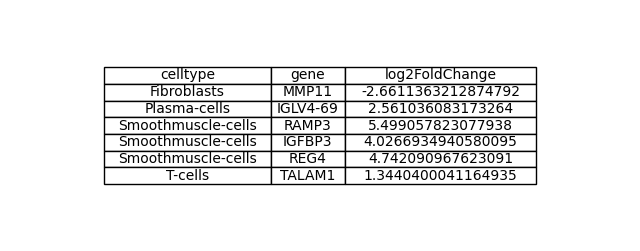

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("30%_dge.csv")
# Filter out Epithelial-cells

# Filter out Epithelial-cells and keep selected columns
filtered_df = df[df['celltype'] != 'Epithelial-cells'][['celltype', 'gene', 'log2FoldChange']]

# Create figure
fig, ax = plt.subplots(figsize=(8, len(filtered_df)*0.5))  # adjust height based on number of rows
ax.axis('off')  # hide axes

# Create table
table = ax.table(cellText=filtered_df.values,
                 colLabels=filtered_df.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0,1,2])

# Save as image
plt.savefig("celltype_table.png", bbox_inches='tight', dpi=300)
plt.show()

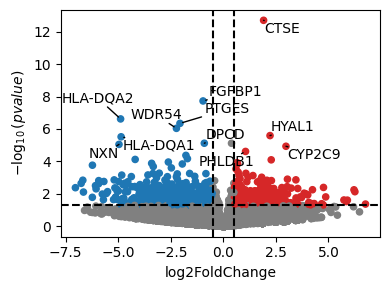

In [91]:
dc.pl.volcano(results['Epithelial-cells'], x="log2FoldChange", y="pvalue",top=11)

In [89]:
r=all_results.reset_index()

# 5.T-cells



In [25]:

cells = {
    "0": "Plasma-cells",
    "1": "B-cells",
    "2": "Epithelial-cells",
    "3": "Epithelial-cells",
    "4": "Epithelial-cells",
    "5": "Epithelial-cells",
    "6": "Epithelial-cells",
    "7": "CD8+-cells",
    "8": "CD4+-cells",
    "9": "Epithelial-cells",
    "10": "Myeloid-cells",
    "11": "B-cells",
    "12": "Myeloid-cells",
    "13": "T-cells",
    "14": "Fibroblasts",
    "15": "CD4+-cells",
    "16": "Myeloid-cells",
    "17": "Fibroblasts",
    "18": "Mast-cells",
    "19": "T-cells",
    "20": "CD8+-cells",
    "21": "T-cells",
    "22": "Endothelial-cells"
}

In [26]:
adata_sc.obs['cells']=adata_sc.obs['leiden'].map(cells)

In [27]:
cd8= adata_sc[adata_sc.obs['cells']== 'CD8+-cells'].copy()
cd8.shape

(3928, 3124)

In [114]:
cd8.write_h5ad(T'cd8.h5ad')

In [11]:
T= T[:, T.var['highly_variable']].copy()



In [12]:
sc.pp.neighbors(T, n_neighbors=30)
sc.tl.umap(T)

In [13]:
# Perform cell clustering using the Leiden algorithm
sc.tl.leiden(T, flavor="igraph", n_iterations=2, resolution = 0.6)

In [28]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(T, groupby="leiden", method="wilcoxon")

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encounter

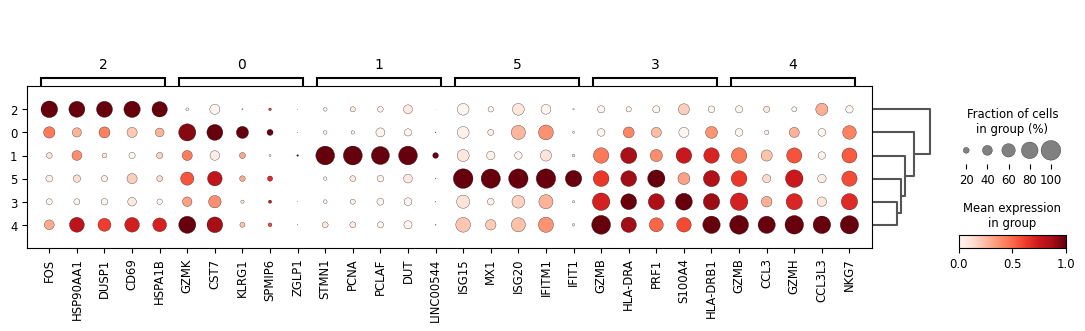

In [30]:
sc.pl.rank_genes_groups_dotplot(T, groupby="leiden", standard_scale="var", n_genes=5)


In [31]:
sc.tl.rank_genes_groups(T, groupby="response", method="wilcoxon")

/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/mannda/miniconda3/envs/alevin_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


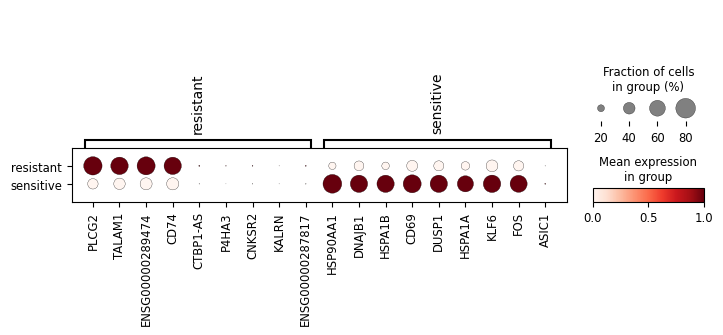

In [37]:
sc.pl.rank_genes_groups_dotplot(T, groupby="response", standard_scale="var", n_genes=9)

In [38]:
df = sc.get.rank_genes_groups_df(T, group='resistant')
#df=df[(df['pvals_adj']<0.05 ) & (abs(df['logfoldchanges'] >0.5))]
#df.to_csv('cd8_diff.csv')
df

names     scores  logfoldchanges          pvals      pvals_adj
0               PLCG2  27.600811             NaN  1.088048e-167  1.088048e-164
1              TALAM1  22.004026             NaN  2.635135e-107  6.587837e-105
2     ENSG00000289474  20.497816             NaN   2.251754e-93   4.094098e-91
3                CD74  18.479242             NaN   3.034157e-76   5.056928e-74
4            CTBP1-AS  18.243603             NaN   2.326050e-74   3.578538e-72
...               ...        ...             ...            ...            ...
1995            DUSP1 -24.250286             NaN  6.566266e-130  2.188755e-127
1996             CD69 -24.681490             NaN  1.690337e-134  6.761350e-132
1997           HSPA1B -25.397175             NaN  2.709756e-142  1.354878e-139
1998           DNAJB1 -26.594767             NaN  7.803329e-156  5.202219e-153
1999         HSP90AA1 -36.540676             NaN  2.507897e-292  5.015795e-289

[2000 rows x 5 columns]

In [624]:

clusters = {}

for cluster in range(6):
    df = sc.get.rank_genes_groups_df(T, group=str(cluster))
    df = df[(df['pvals_adj'] < 0.05) & (df['logfoldchanges'] > 0.5)]
    clusters[cluster] =set(df['names'])


    
    

In [ ]:
result1 = pd.concat(clusters, names=['cluster', 'gene'])
result1

In [ ]:
result1.to_csv('cd8_genes.csv')

In [627]:


# Read the Excel file, skipping the first row
paper_df = pd.read_excel("/home/mannda/Downloads/mmc3.xlsx", header=1)

#for CD in paper_df['cluster']:
paper_df= paper_df[paper_df['cluster'].str.startswith('CD8')]
paper_df= paper_df[(paper_df['p_val_adj'] <0.05) & (paper_df['avg_log2FC'] > 1)]

paper_df

    


Gene_name        pvalue  avg_log2FC  pct exp in cluster  \
832      "GZMK"  0.000000e+00    2.833778               0.955   
833      "CMC1"  0.000000e+00    1.683361               0.447   
834      "CST7"  0.000000e+00    1.553853               0.848   
835     "KLRG1"  0.000000e+00    1.516091               0.350   
836      "CD74"  0.000000e+00    0.973509               0.818   
...         ...           ...         ...                 ...   
2609     "SFPQ"  4.882567e-11    0.280088               0.429   
2610    "TRA2A"  9.154897e-11    0.274904               0.259   
2611    "ODF2L"  1.111120e-10    0.288614               0.307   
2612  "MT-ND4L"  1.909241e-09    0.257361               0.410   
2613     "CCL4"  1.924963e-09    0.699232               0.431   

      pct exp in other cluster  p_val_adj  cluster  
832                      0.191   0.000000  CD8+Tem  
833                      0.122   0.000000  CD8+Tem  
834                      0.439   0.000000  CD8+Tem  
835                      0.060   0.000000  CD8+Tem  
836                      0.603   0.000000  CD8+Tem  
...                        ...        ...      ...  
2609                     0.357   0.000001  CD8+IEL  
2610                     0.195   0.000002  CD8+IEL  
2611                     0.241   0.000003  CD8+IEL  
2612                     0.342   0.000048  CD8+IEL  
2613                     0.366   0.000048  CD8+IEL  

[1153 rows x 7 columns]

In [628]:
clusters2 = {}

# Loop through each unique cluster in paper_df
for cluster_name in paper_df['cluster'].unique():
    genes = set(paper_df[paper_df['cluster'] == cluster_name]['Gene_name'])
    clusters2[cluster_name] = genes


In [629]:
clusters2

{'CD8+Tem': {'"AC245297.3"',
  '"AKNA"',
  '"APOBEC3G"',
  '"ATM"',
  '"BTG1"',
  '"BTN3A2"',
  '"CCL4"',
  '"CCL4L2"',
  '"CCL5"',
  '"CD27"',
  '"CD44"',
  '"CD48"',
  '"CD74"',
  '"CD81"',
  '"CD84"',
  '"CD8A"',
  '"CD8B"',
  '"CD99"',
  '"CDC42SE2"',
  '"CLDND1"',
  '"CLEC2B"',
  '"CMC1"',
  '"CST7"',
  '"CTSW"',
  '"CXCR4"',
  '"CYBA"',
  '"DENND2D"',
  '"DGKZ"',
  '"DUSP2"',
  '"EMP3"',
  '"FTL"',
  '"GCC2"',
  '"GIMAP1"',
  '"GIMAP4"',
  '"GIMAP7"',
  '"GUK1"',
  '"GZMA"',
  '"GZMH"',
  '"GZMK"',
  '"GZMM"',
  '"HCST"',
  '"HLA-A"',
  '"HLA-C"',
  '"HLA-DPA1"',
  '"HLA-DPB1"',
  '"HLA-DQA1"',
  '"HLA-DQB1"',
  '"HLA-DRA"',
  '"HLA-DRB1"',
  '"HLA-E"',
  '"HLA-F"',
  '"IGHA1"',
  '"IGHA2"',
  '"IGHG1"',
  '"IGKC"',
  '"IGLC2"',
  '"IGLC3"',
  '"ITGB2"',
  '"ITM2C"',
  '"JCHAIN"',
  '"KIAA1551"',
  '"KLF2"',
  '"KLRG1"',
  '"LIMD2"',
  '"LITAF"',
  '"LYAR"',
  '"LYST"',
  '"LYZ"',
  '"MALAT1"',
  '"MIAT"',
  '"N4BP2L2"',
  '"NKG7"',
  '"PCSK7"',
  '"PIK3R1"',
  '"PPDPF"',
  '"PPP

In [633]:
CD8_plus = {
    "0": "Tem",
    "1": "IEL",
    "2": "Trm-mitotic",
    "3": "Trm/Tem",
    "4": "Trm/Tem",
    "5": "Trm"
}


In [634]:
T.obs['cd8']=T.obs['leiden'].map(CD8_plus)

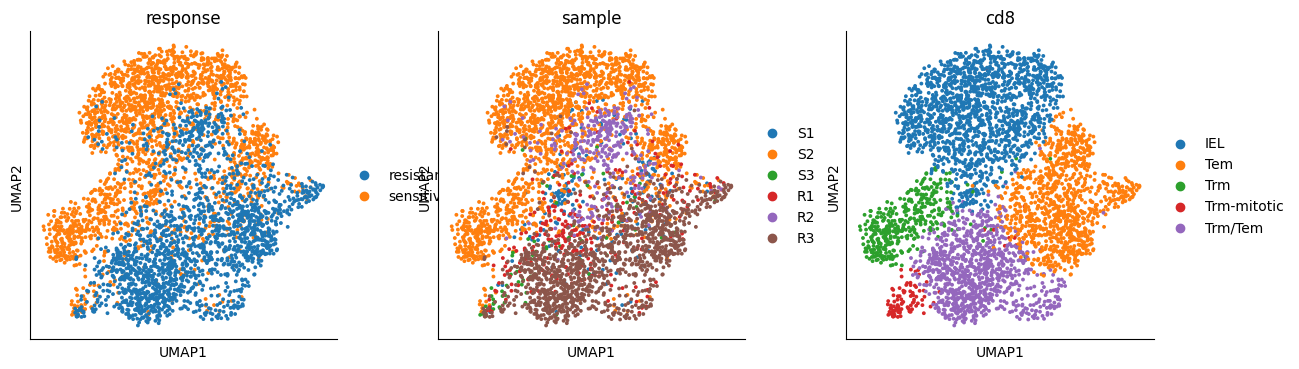

In [671]:
sc.pl.umap(T, color=['response','sample', 'cd8',] )

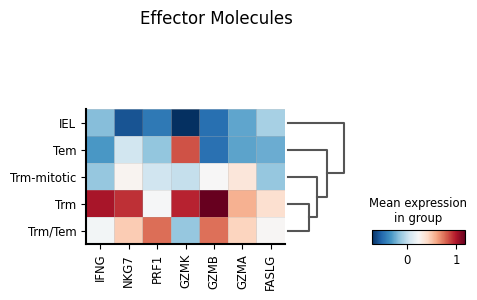

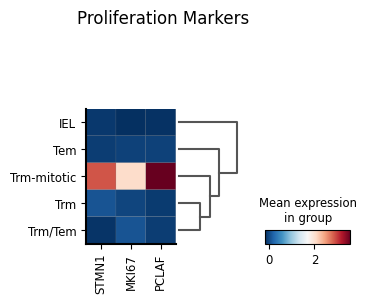

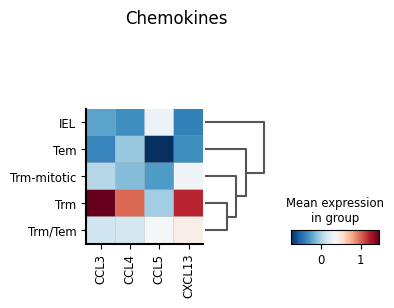

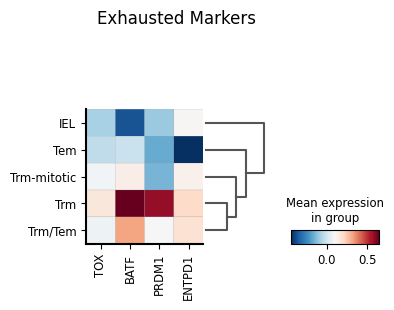

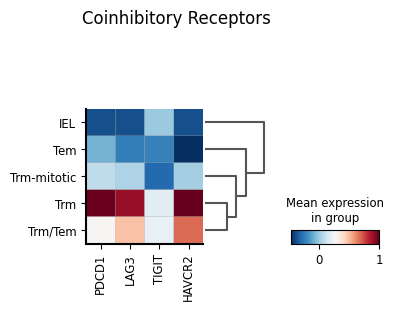

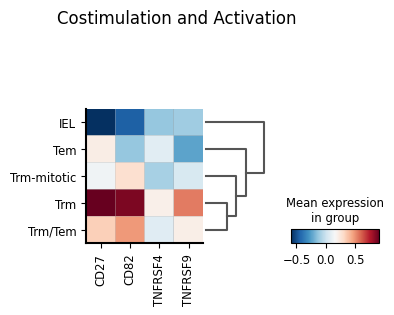

In [664]:
import scanpy as sc

gene_groups = {
    "Effector Molecules": ['IFNG','NKG7','PRF1','GZMK','GZMB','GZMA','FASLG'],
    "Proliferation Markers": ['STMN1','MKI67','PCLAF'],
    "Chemokines": ['CCL3','CCL4','CCL5','CXCL13'],
    "Exhausted Markers": ['TOX','BATF','PRDM1','ENTPD1'],
    "Coinhibitory Receptors": ['PDCD1','LAG3','TIGIT','HAVCR2'],
    "Costimulation and Activation": ['CD27','CD82','TNFRSF4','TNFRSF9']
}

# Create dendrogram once
sc.tl.dendrogram(T, groupby="cd8")

# Loop over groups
for title, genes in gene_groups.items():
    sc.pl.matrixplot(
        adata=T,
        var_names=genes,
        groupby="cd8",
        dendrogram=True,
        cmap="RdBu_r",
        title=title
    )



In [75]:
# Create pseudobulk profiles by summing the raw counts ('counts' layer)
# for each cell type within each sample.
pdata = dc.pp.pseudobulk(
    adata=adata,
    sample_col="sample",
    groups_col="celltype",
    mode="sum",
    layer= 'counts'
)

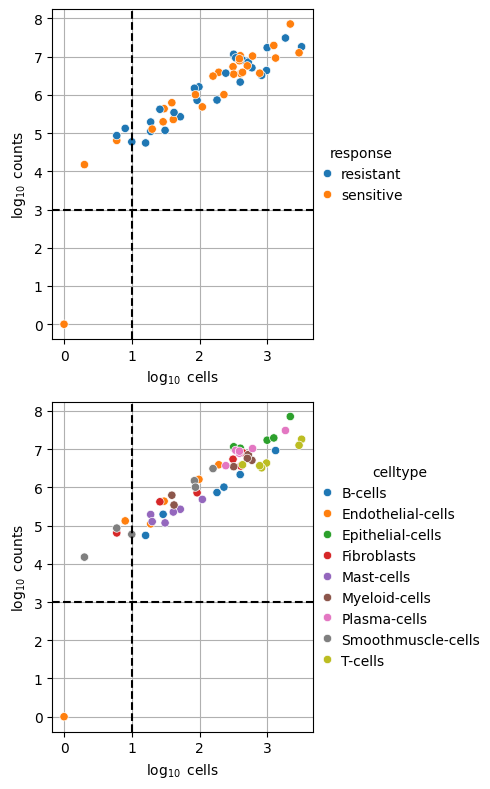

In [76]:
# Visualize the number of cells contributing to each pseudobulk sample to identify any with low cell counts
dc.pl.filter_samples(
    adata=pdata,
    groupby=["response", "celltype"],
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

In [77]:
# Filter out any pseudobulk samples that were derived from fewer than 20 cells
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

In [78]:
pdata.layers["counts"] = pdata.X.copy()

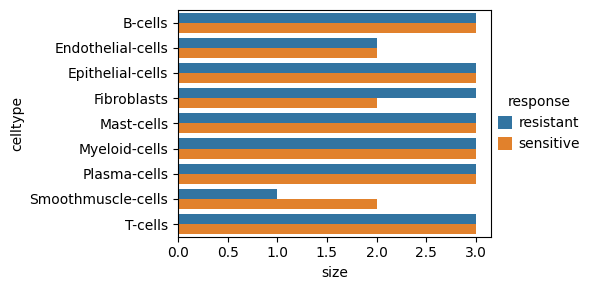

In [79]:
# Plot the number of pseudobulk samples available for each cell type and condition
dc.pl.obsbar(adata=pdata, y="celltype", hue="response", figsize=(6, 3))

<function matplotlib.pyplot.show(close=None, block=None)>

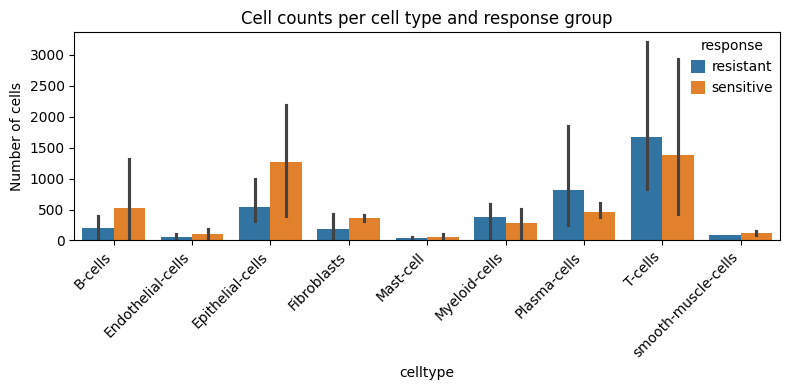

In [80]:
import seaborn as sns
cells = pd.read_csv('cells.csv')
plt.figure(figsize=(8, 4))
sns.barplot(data= cells , x= 'celltype', y = 'psbulk_cells', hue='response')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of cells")
plt.title("Cell counts per cell type and response group")
plt.tight_layout()
plt.show

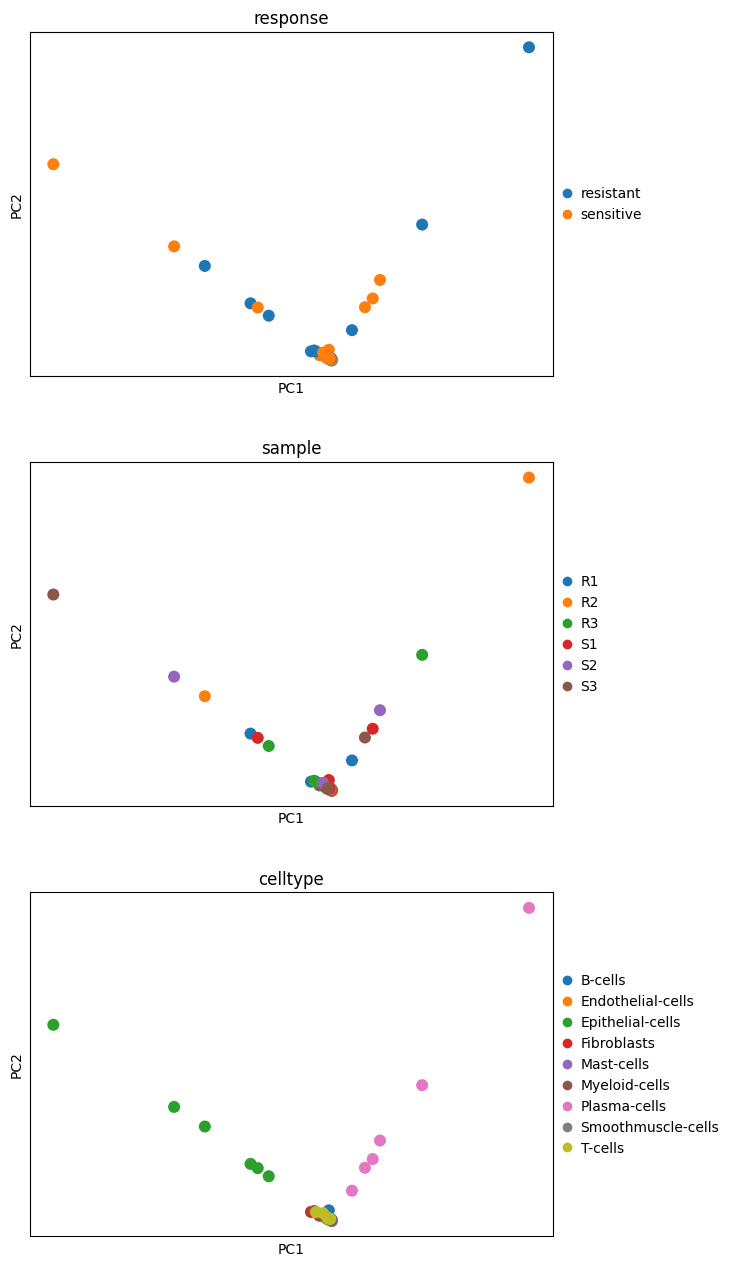

In [82]:
# Run PCA on the pseudobulk data to visualize the main sources of variation
sc.tl.pca(pdata)
sc.pl.pca(
    pdata,
    color=["response","sample","celltype"],
    ncols=1,
    size=300,
    frameon=True,
)

In [669]:
B

AnnData object with n_obs × n_vars = 3928 × 30687
    obs: 'barcodes', 'sample', 'response', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'predict_type', 'predict_score', 'cells', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'draw_graph', 'graph', 'hvg', 'log1p', 'milestones_colors', 'neighbors', 'pca', 'ppt', 'pseudotime_list', 'response_colors', 'sample_colors', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_draw_graph_fa', 'X_palantir', 'X_p